# Importing Required Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import csv
import sys
import time

# RDKit for molecular descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Machine Learning Models
from sklearn import linear_model, svm, neural_network, ensemble
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Importing Dataset

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/yus11x11/Machine-Learning-models-for-predicting-enthalpy-of-vaporization-from-molecular-descriptors/main/dataset.csv"
data = pd.read_csv(url)




In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CAS       2410 non-null   object 
 1   VOC       2410 non-null   object 
 2   dvap      2410 non-null   float64
 3   num       2410 non-null   int64  
 4   External  2410 non-null   object 
 5   SMILES    2410 non-null   object 
 6   Key       2410 non-null   object 
 7   Family    2410 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 150.8+ KB


In [4]:
data.shape

(2410, 8)

In [5]:
data.describe()

dvap          num
count  2410.000000  2410.000000
mean     61.808091     1.600415
std      32.334840     1.251019
min      15.600000     1.000000
25%      42.300000     1.000000
50%      54.800000     1.000000
75%      71.275000     2.000000
max     387.200000    12.000000

In [6]:
data["Family"].value_counts()

Family
Hydrocarbons                        452
Benzenoids                          426
Lipids and lipid-like molecules     371
Organic oxygen compounds            319
Organoheterocyclic compounds        240
Organohalogen compounds             206
Organic acids and derivatives       150
Organic nitrogen compounds          127
Organosulfur compounds               68
Organic 1,3-dipolar compounds        20
Phenylpropanoids and polyketides     13
Acetylides                            6
Other                                 5
Allenes                               3
Organophosphorus compounds            3
Homogeneous non-metal compounds       1
Name: count, dtype: int64

In [7]:
data.isna().sum()

CAS         0
VOC         0
dvap        0
num         0
External    0
SMILES      0
Key         0
Family      0
dtype: int64

In [8]:
for column in data.columns:
    print(column)

CAS
VOC
dvap
num
External
SMILES
Key
Family


## Getting Deciptors from Rdkit 

In [227]:


descriptor_tuples = Descriptors._descList
my_descriptors = [name for name, function in descriptor_tuples]

# 2. Define a function to calculate descriptors for one SMILES string
def calculate_descriptors(smiles):
    """
    Calculates a list of RDKit descriptors for a given SMILES string.
    Returns a dictionary of {descriptor_name: value}.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    
    # Handle cases where SMILES is invalid
    if mol is None:
        return {desc: None for desc in my_descriptors}

    results = {}
    for desc in my_descriptors:
        # Use getattr() - it's safer and cleaner than eval()
        try:
            results[desc] = getattr(Descriptors, desc)(mol)
        except Exception:
            results[desc] = None # Handle calculation errors
    return results


print("Calculating descriptors...")
descriptor_series = data['SMILES'].apply(calculate_descriptors)

# 4. Convert the Series of dictionaries into a new DataFrame
# .tolist() converts the Series to a list of dicts, which pd.DataFrame handles
descriptor_df = pd.DataFrame(descriptor_series.tolist(), index=data.index)

final_data=pd.concat([data, descriptor_df], axis=1)
final_data.drop(columns=["Ipc"], inplace=True)


Calculating descriptors...


In [228]:
categorical_cols = final_data.select_dtypes(include=['object', 'category']).columns.tolist()

In [229]:
categorical_cols

['CAS', 'VOC', 'External', 'SMILES', 'Key', 'Family']

## Scalling and feature Engineering

<Axes: ylabel='Frequency'>

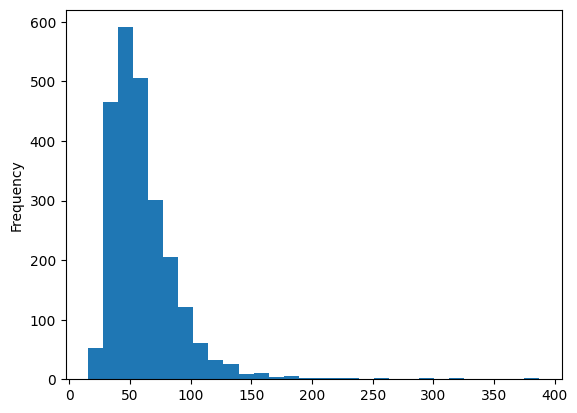

In [230]:
final_data["dvap"].plot.hist(bins=30)

<Axes: ylabel='Frequency'>

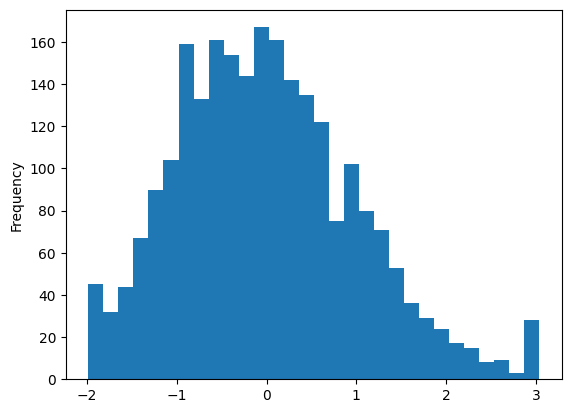

In [231]:

# Drop NA and clip outliers
final_data["dvap"] = final_data["dvap"].clip(lower=final_data["dvap"].quantile(0.01),
                                 upper=final_data["dvap"].quantile(0.99))

# Log-transform to reduce skew
final_data["dvap_log"] = np.log1p(final_data["dvap"])

# Standardize
scaler = StandardScaler()
final_data["dvap_scaled"] = scaler.fit_transform(final_data[["dvap_log"]])
final_data["dvap_scaled"].plot.hist(bins=30)

In [232]:
final_data.shape

(2410, 226)

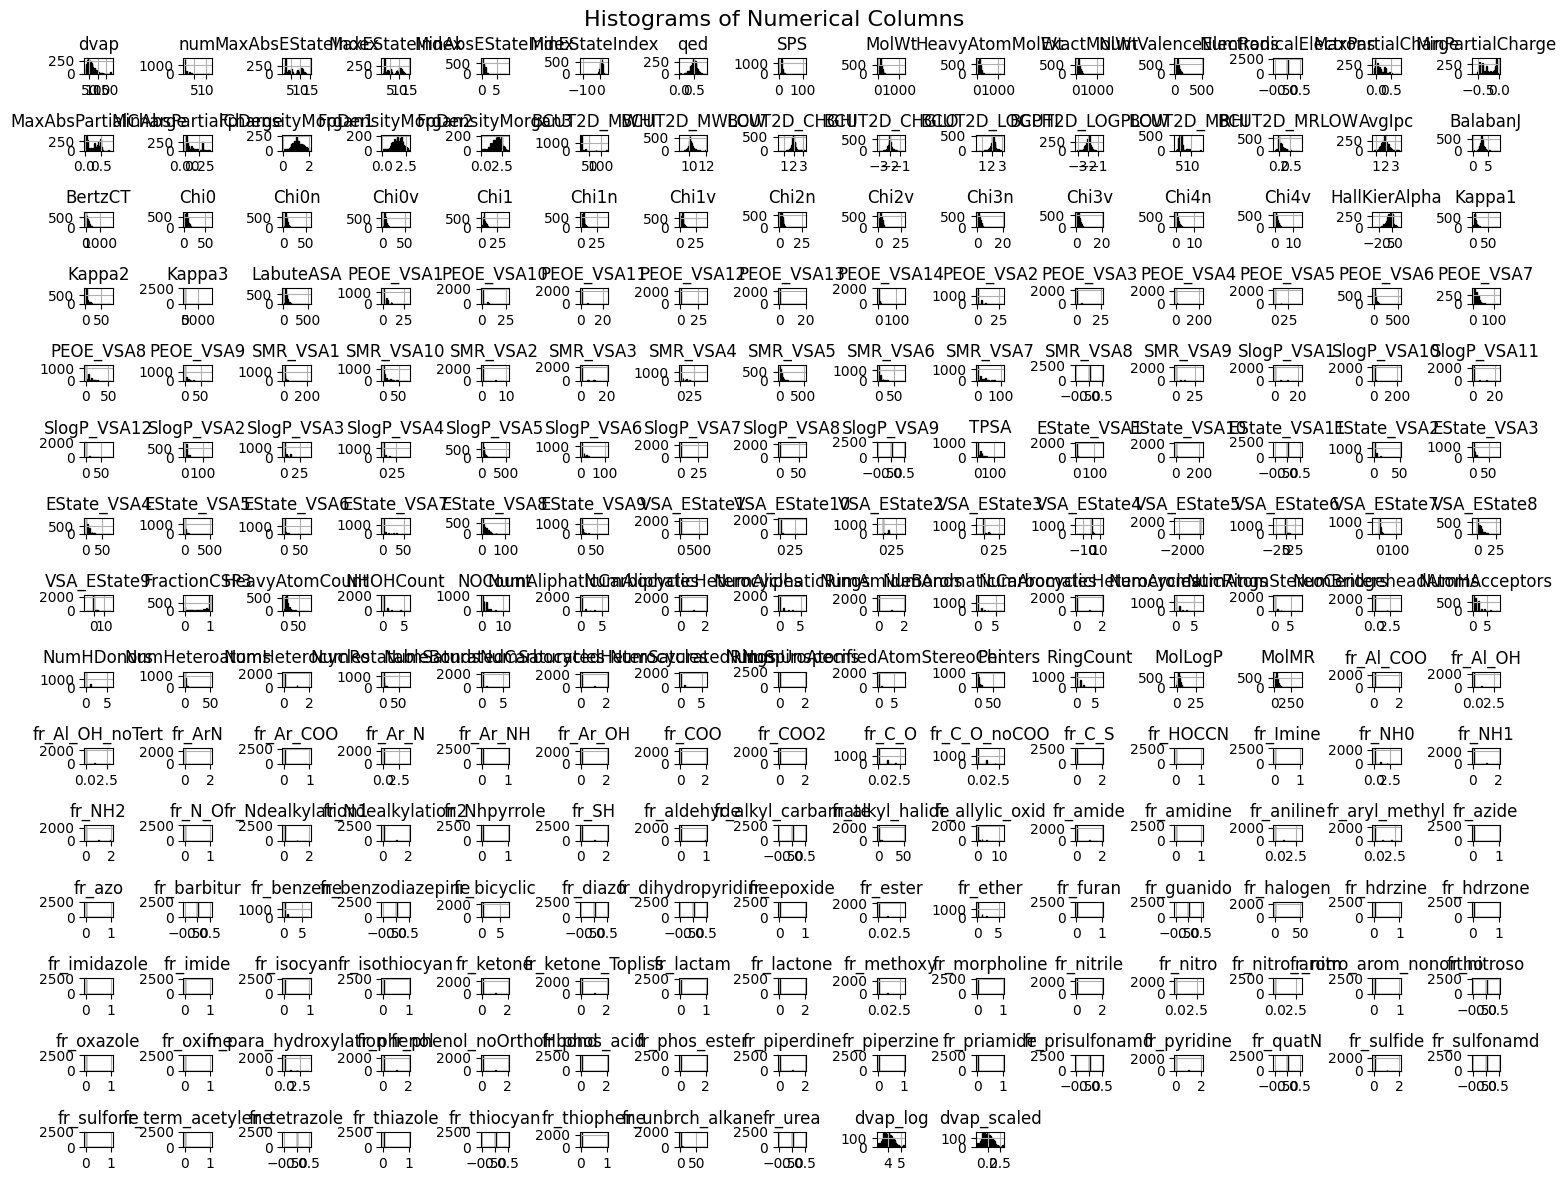

In [233]:
# Select only numerical columns
numeric_cols = final_data.select_dtypes(include=['number']).columns

# Plot histograms
final_data[numeric_cols].hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.tight_layout()
plt.show()

In [234]:
scaler1 = StandardScaler()
final_data_scaled = final_data.copy()
final_data_scaled[numeric_cols] = scaler.fit_transform(final_data[numeric_cols])



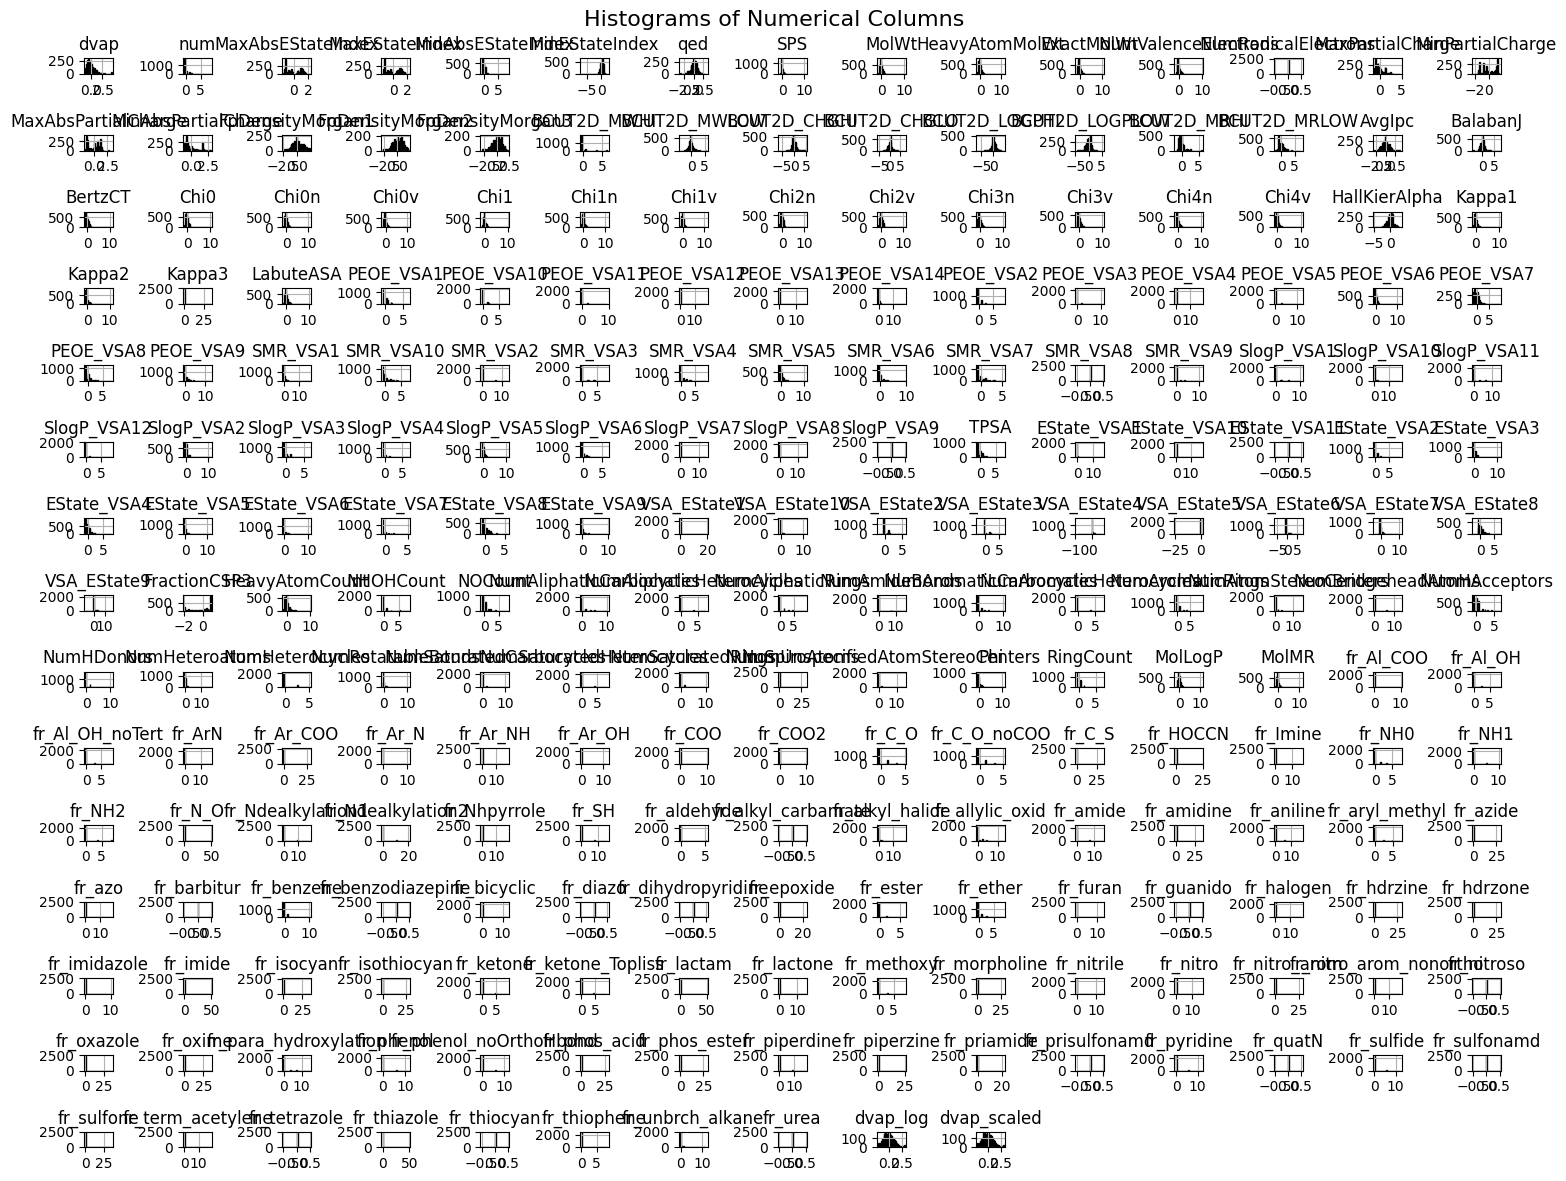

In [235]:
# Select only numerical columns
numeric_cols = final_data_scaled.select_dtypes(include=['number']).columns

# Plot histograms
final_data_scaled[numeric_cols].hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Columns", fontsize=16)
plt.tight_layout()
plt.show()

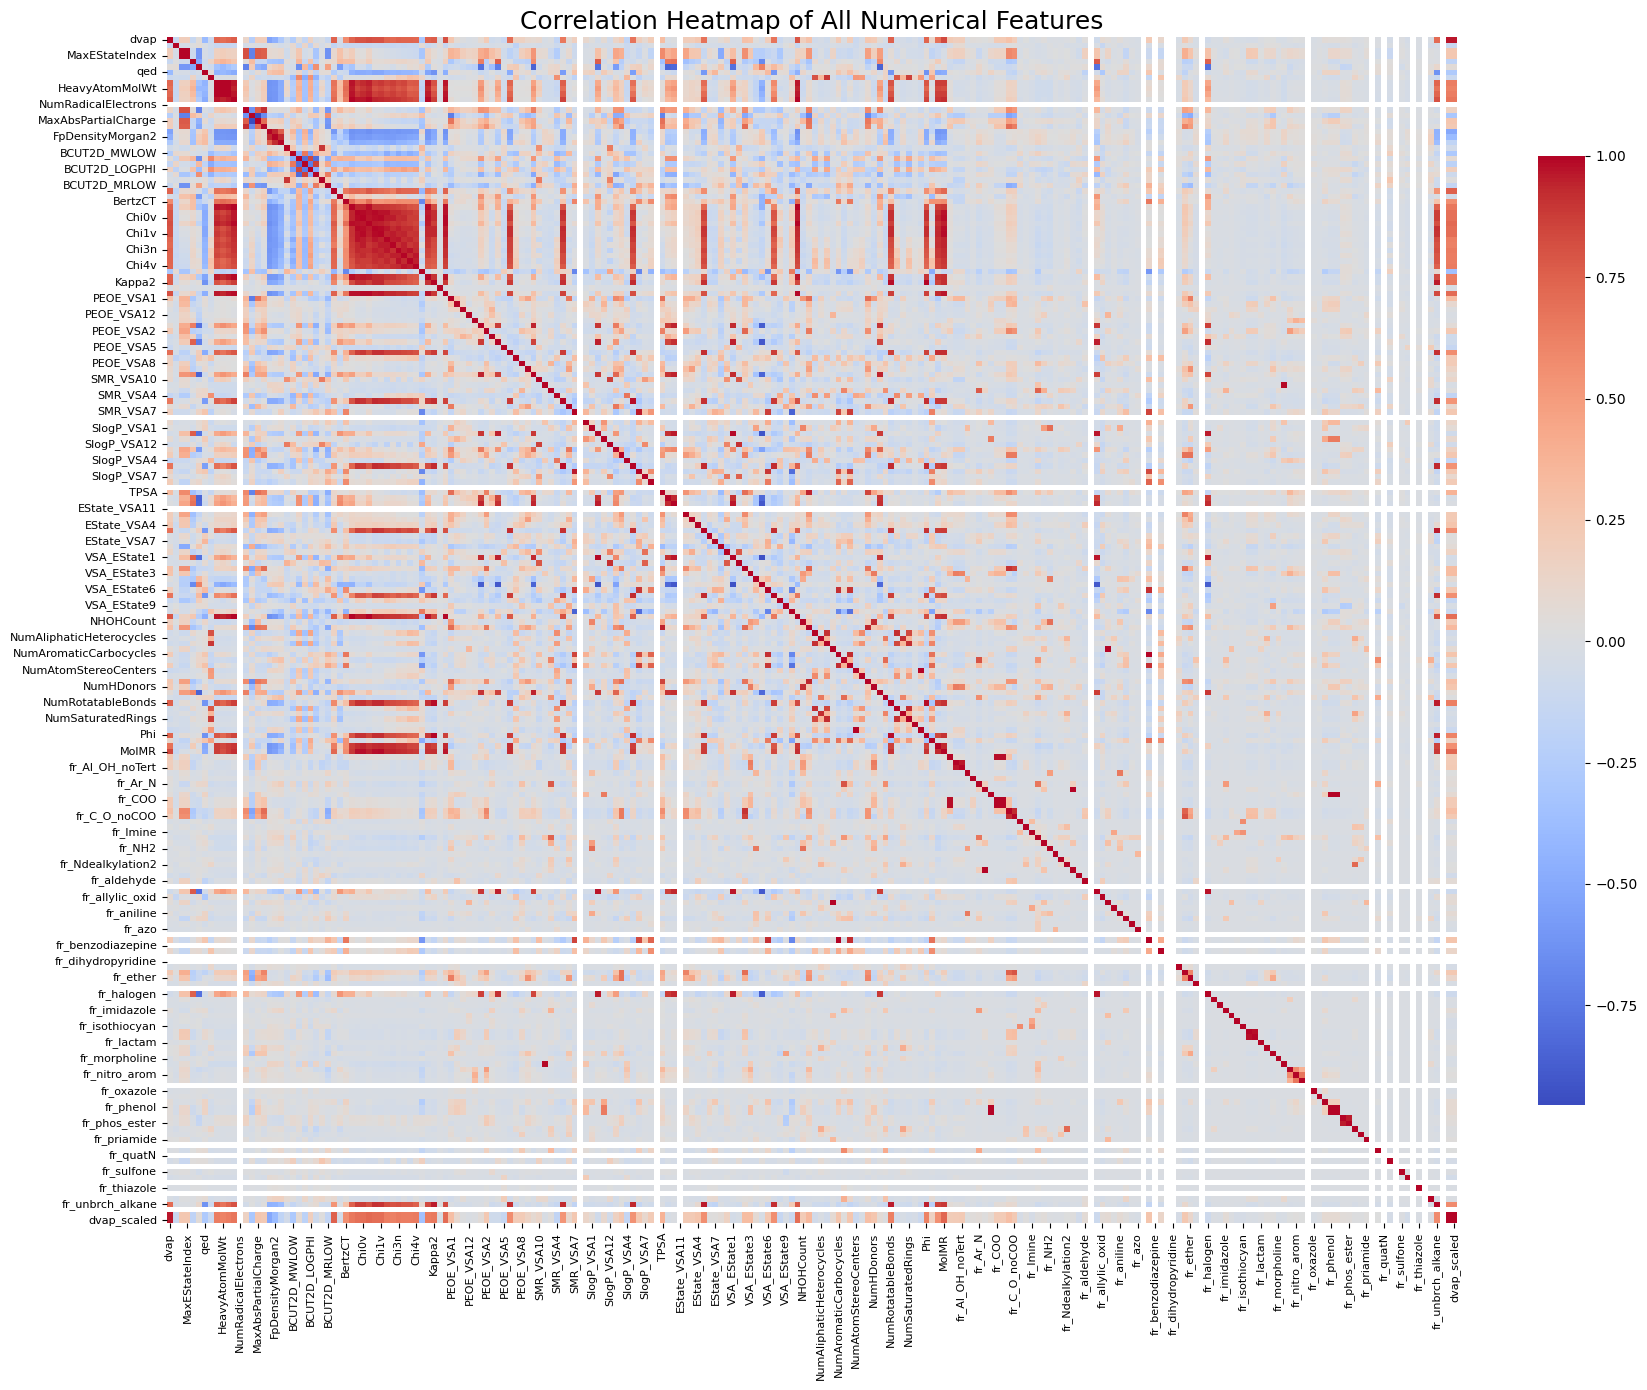

In [236]:


# Compute correlation matrix
corr = final_data[numeric_cols].corr()

# Plot readable full heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=False,          # Disable text for readability
    square=False,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of All Numerical Features", fontsize=18)
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


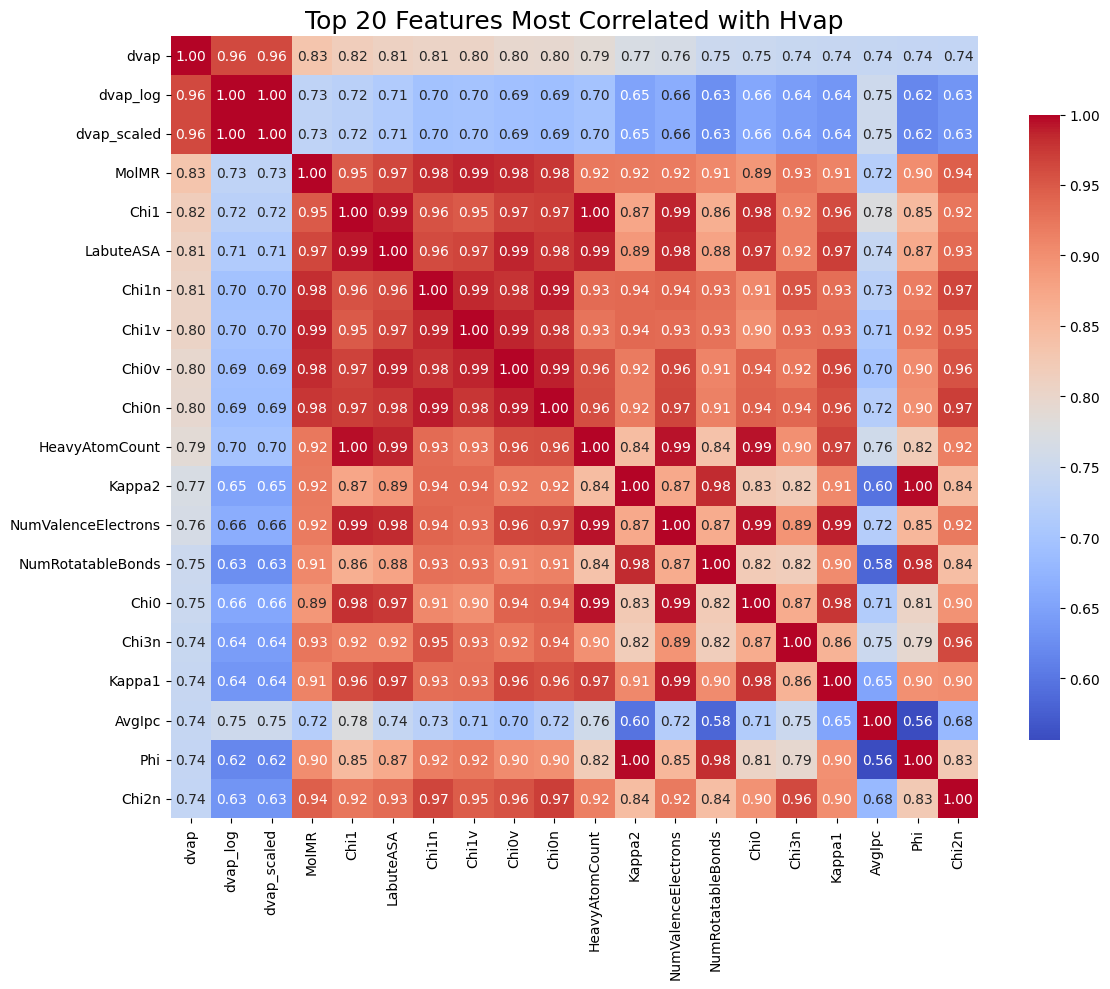

In [237]:


target = "dvap"  # change to your actual column name

# Get correlations with target and sort
corr_with_target = final_data[numeric_cols].corr()[target].abs().sort_values(ascending=False)

# Select top 20 most correlated features
top_features = corr_with_target.head(20).index

plt.figure(figsize=(12, 10))
sns.heatmap(
    final_data[top_features].corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8}
)
plt.title("Top 20 Features Most Correlated with Hvap", fontsize=18)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Training  Different Models 

In [238]:
exclude_cols = ['CAS', 'VOC', 'dvap', 'num', 'External', 'SMILES', 'Key', 'Family','dvap_log','dvap_scaled']
X_names = [col for col in final_data.columns if col not in exclude_cols]
X = final_data.drop(columns=exclude_cols)
y = final_data['dvap'].to_numpy()

In [239]:


# -------------------------------------------
# Define models
# -------------------------------------------
models = [
    linear_model.LinearRegression(),
    RandomForestRegressor(random_state=47),
    ensemble.GradientBoostingRegressor(random_state=47),
    svm.SVR(),
    neural_network.MLPRegressor(random_state=47, max_iter=500),
    Ridge(alpha=1.0, random_state=47),
    Lasso(alpha=0.001, random_state=47),
    ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=47)
]
models += [
    XGBRegressor(random_state=47, n_estimators=500, learning_rate=0.05, max_depth=6),
    LGBMRegressor(random_state=47, n_estimators=500, learning_rate=0.05, max_depth=-1),
    CatBoostRegressor(random_seed=47, verbose=False)
]



🔹 Training LinearRegression...


Fitting LinearRegression: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 28.52it/s]


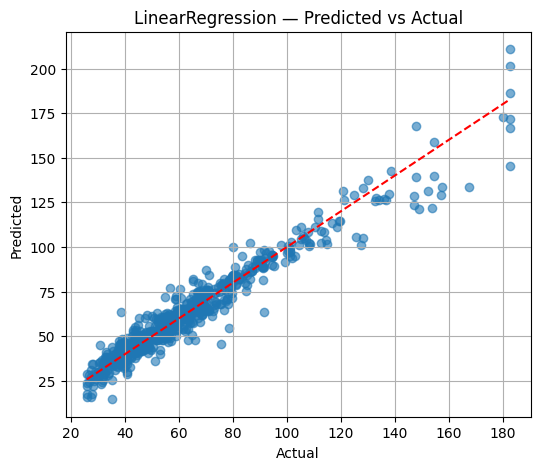

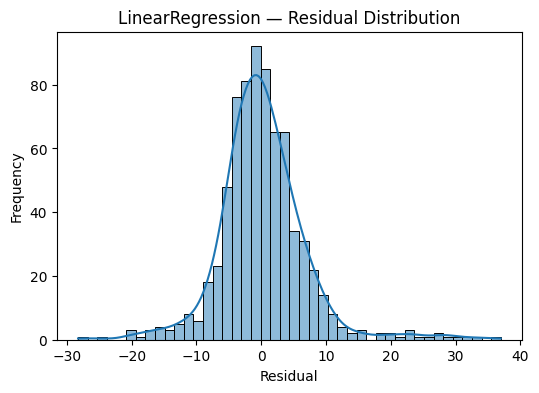

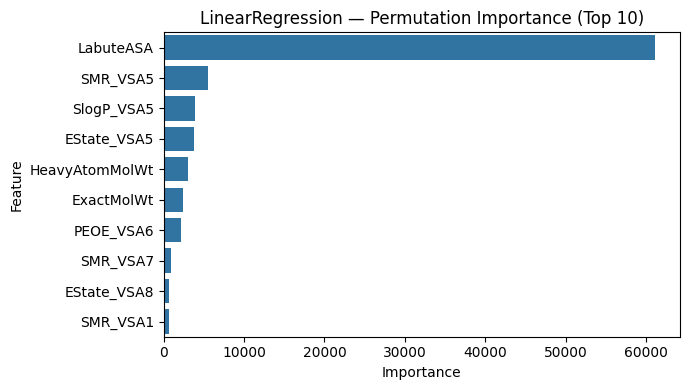


🔹 Training RandomForestRegressor...


Fitting RandomForestRegressor: 100%|██████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


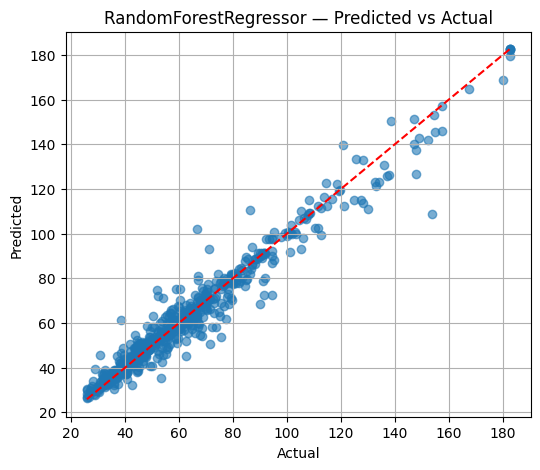

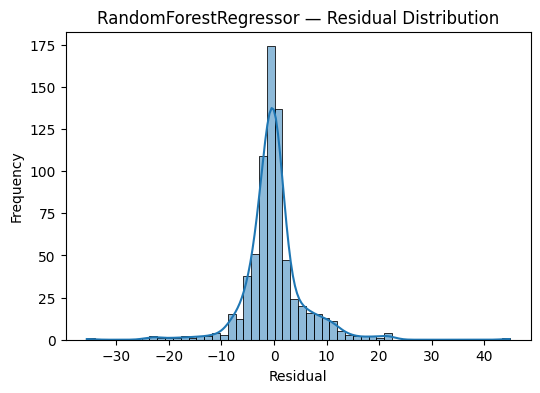

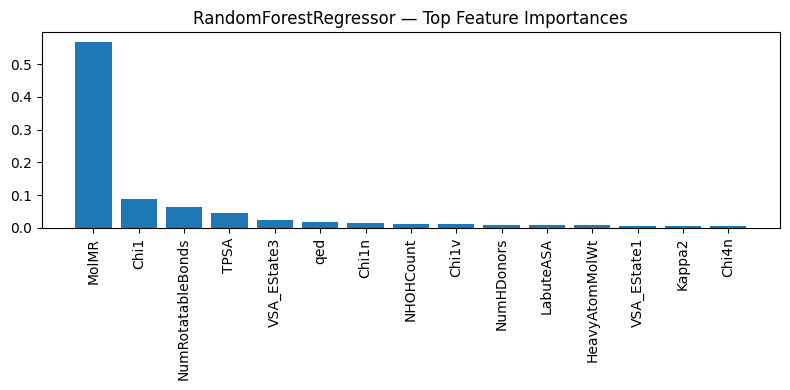

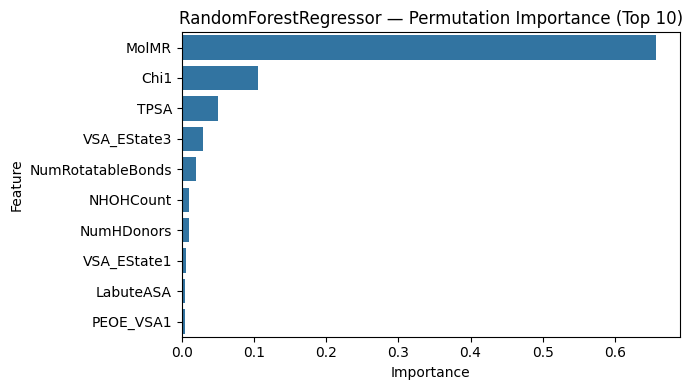


🔹 Training GradientBoostingRegressor...


Fitting GradientBoostingRegressor: 100%|██████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


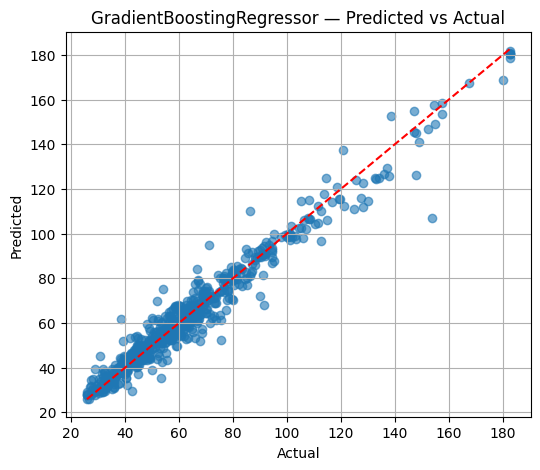

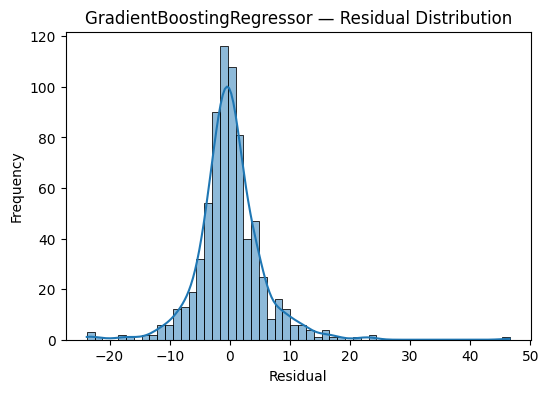

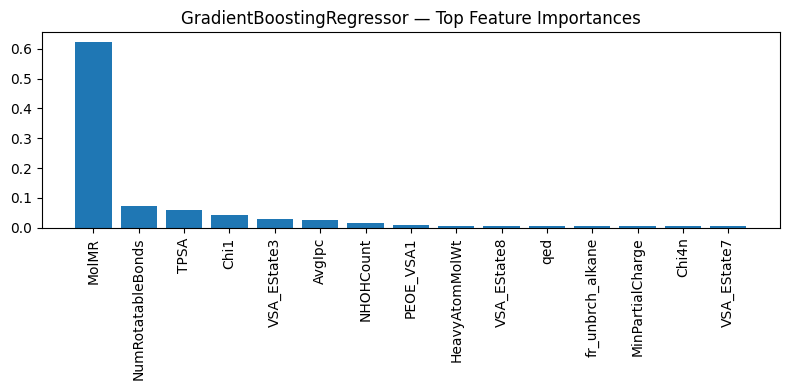

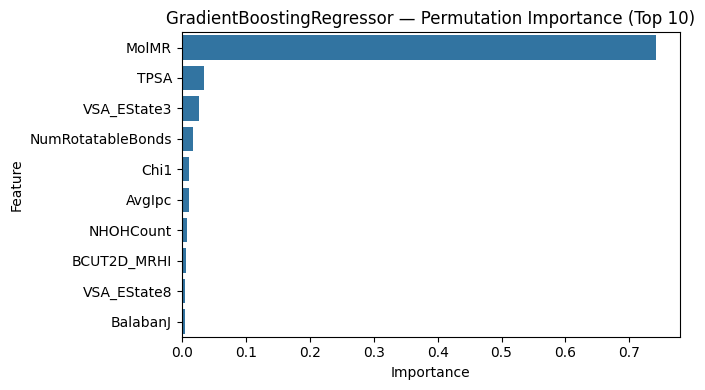


🔹 Training SVR...


Fitting SVR: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


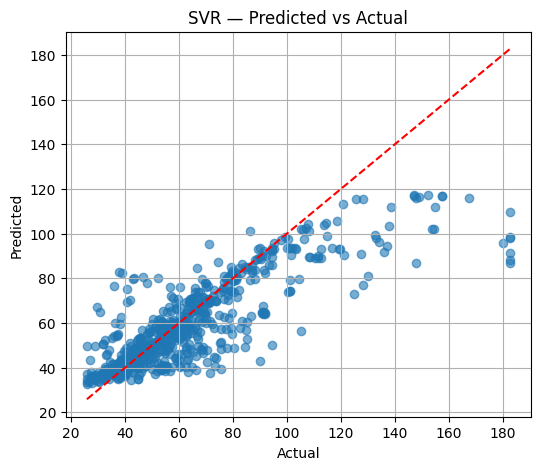

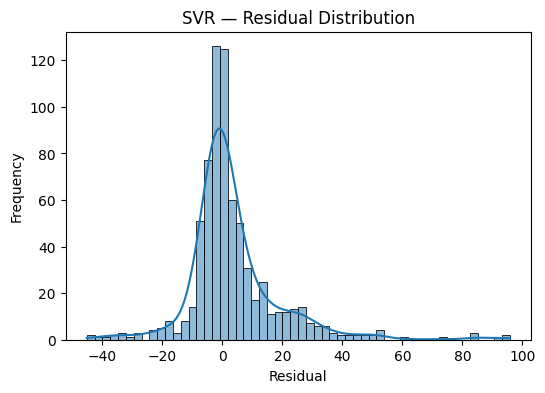

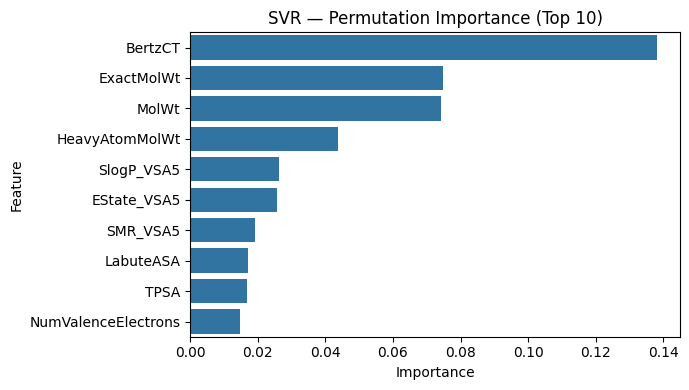


🔹 Training MLPRegressor...


Fitting MLPRegressor: 100%|███████████████████████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


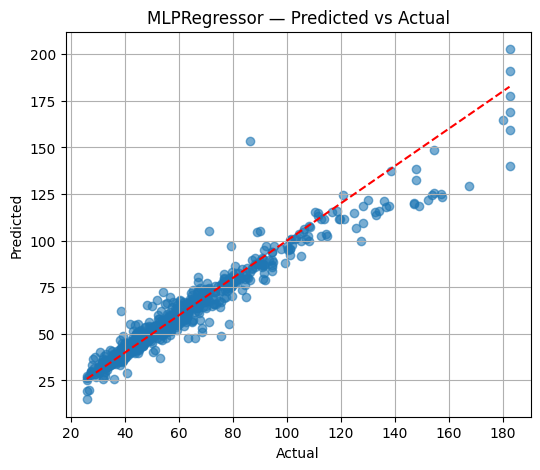

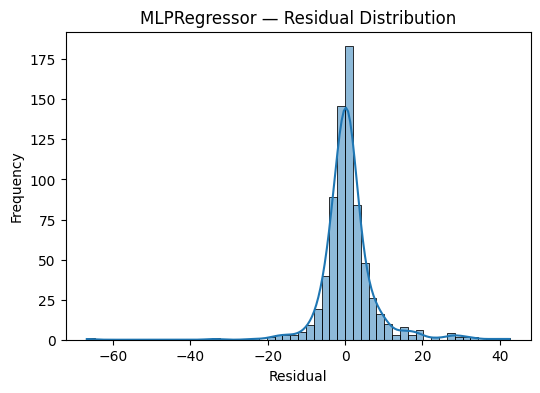

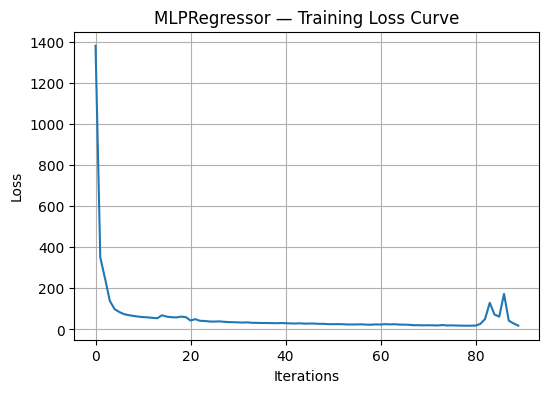

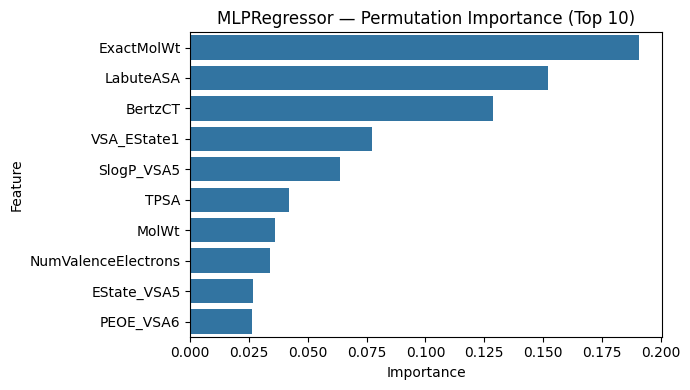


🔹 Training Ridge...


Fitting Ridge: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.85it/s]


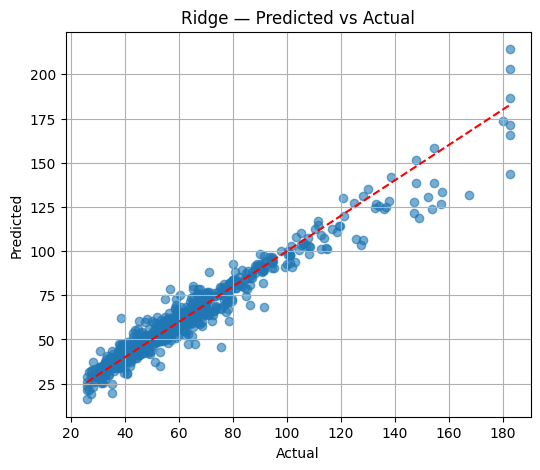

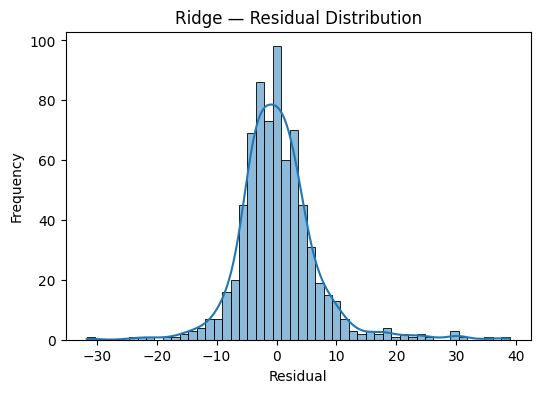

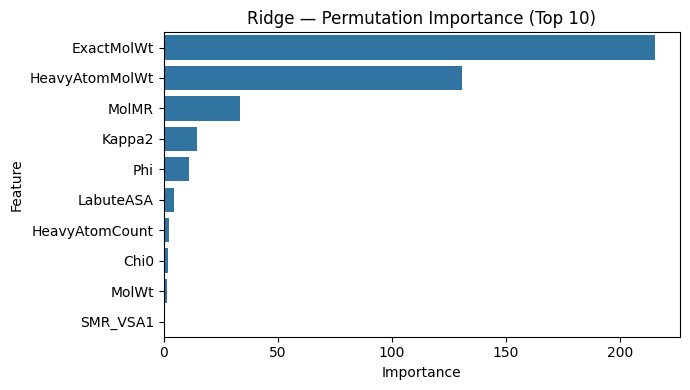


🔹 Training Lasso...


Fitting Lasso:   0%|                                                          | 0/1 [00:00<?, ?it/s]c:\AYUSH\Ayush\IIT KANPUR\SEMESTER 5\CHE657\PROJECT\che\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+04, tolerance: 1.195e+02
  model = cd_fast.enet_coordinate_descent(
Fitting Lasso: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


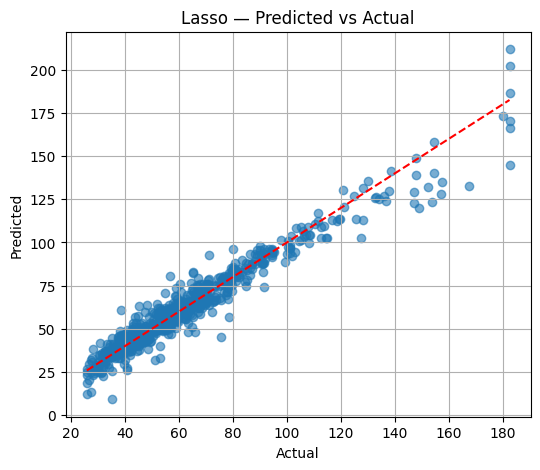

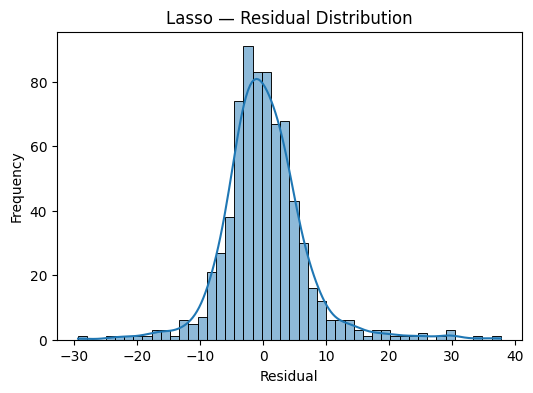

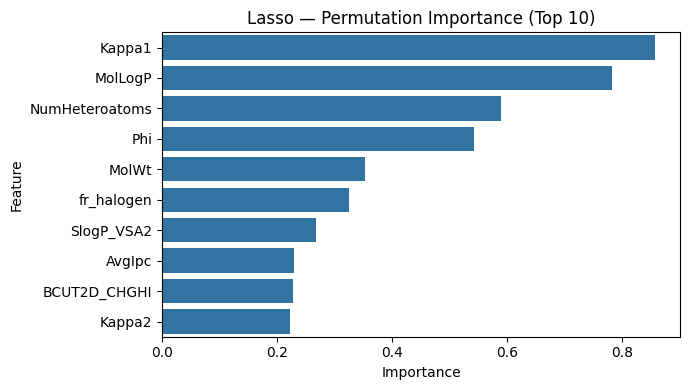


🔹 Training ElasticNet...


Fitting ElasticNet:   0%|                                                     | 0/1 [00:00<?, ?it/s]c:\AYUSH\Ayush\IIT KANPUR\SEMESTER 5\CHE657\PROJECT\che\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.357e+04, tolerance: 1.195e+02
  model = cd_fast.enet_coordinate_descent(
Fitting ElasticNet: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


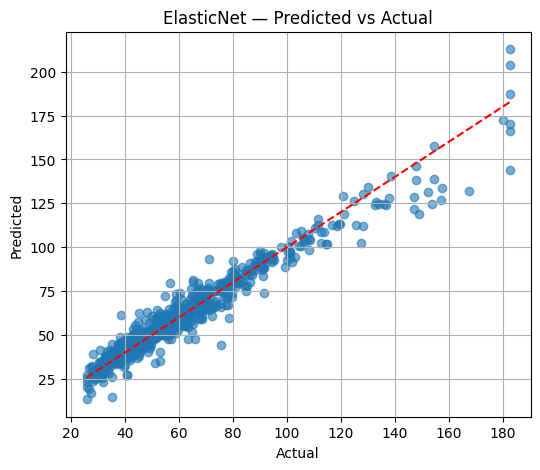

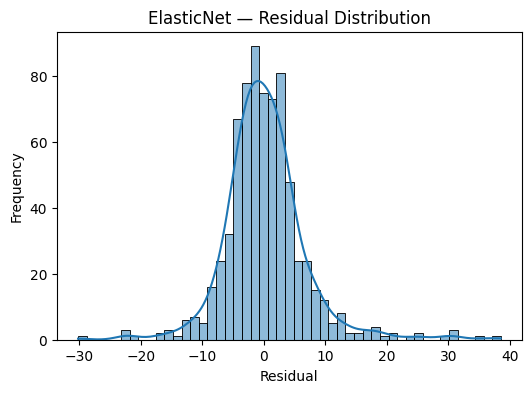

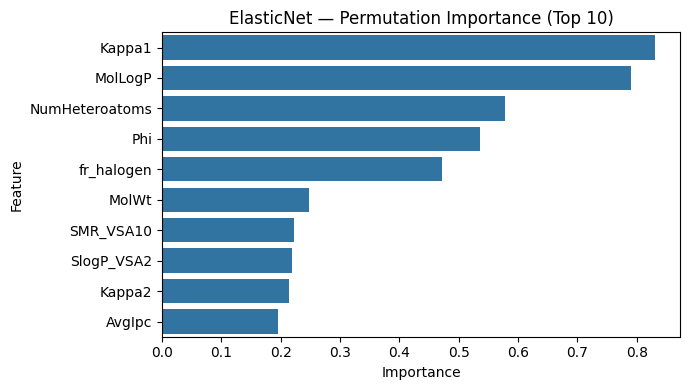


🔹 Training XGBRegressor...


Fitting XGBRegressor: 100%|███████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


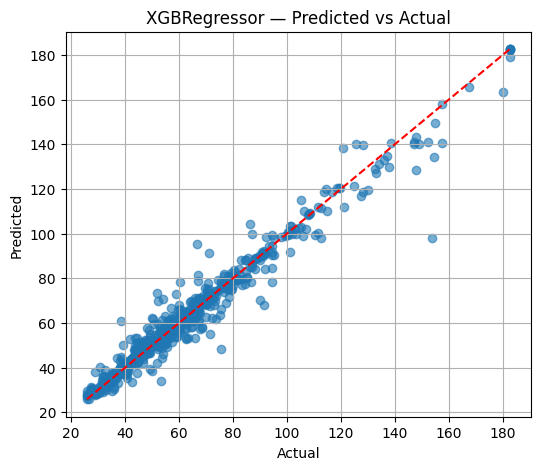

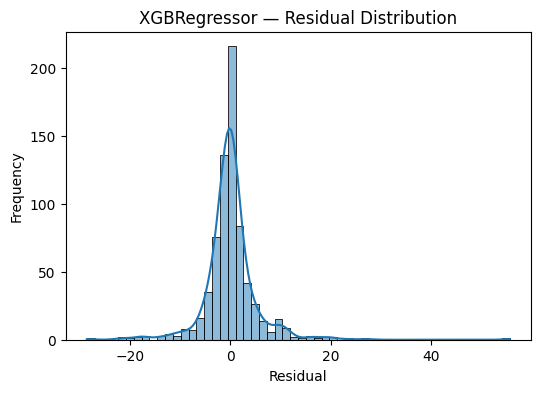

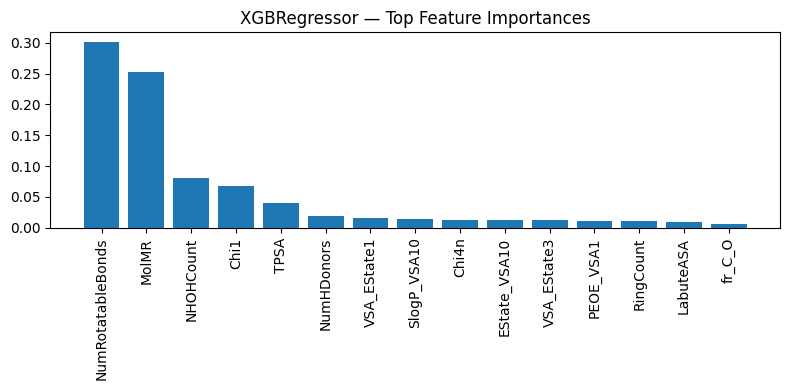

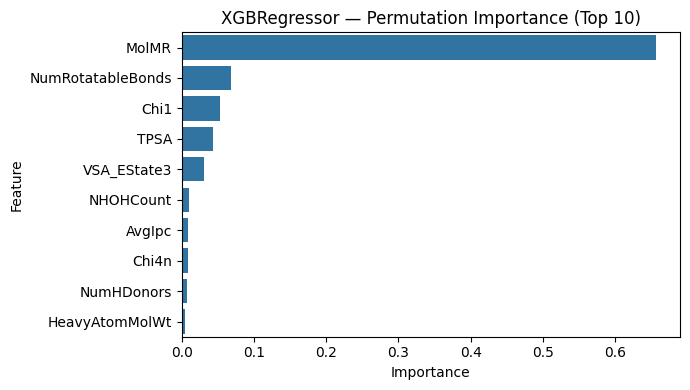


🔹 Training LGBMRegressor...


Fitting LGBMRegressor:   0%|                                                  | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16602
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 163
[LightGBM] [Info] Start training from score 60.731768


Fitting LGBMRegressor: 100%|██████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


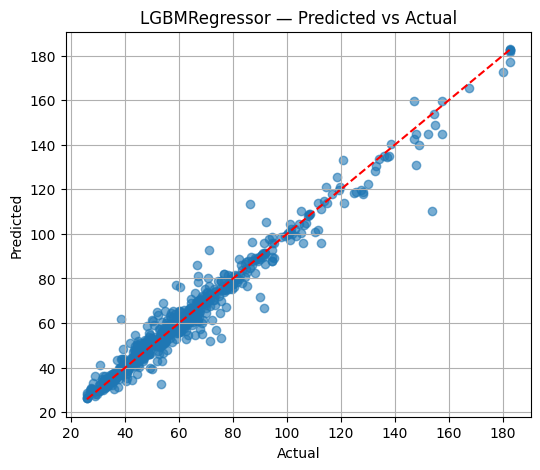

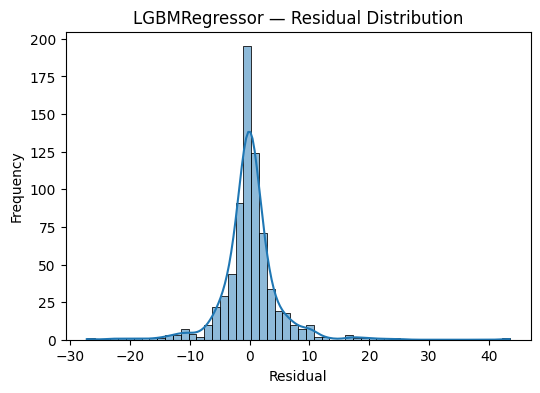

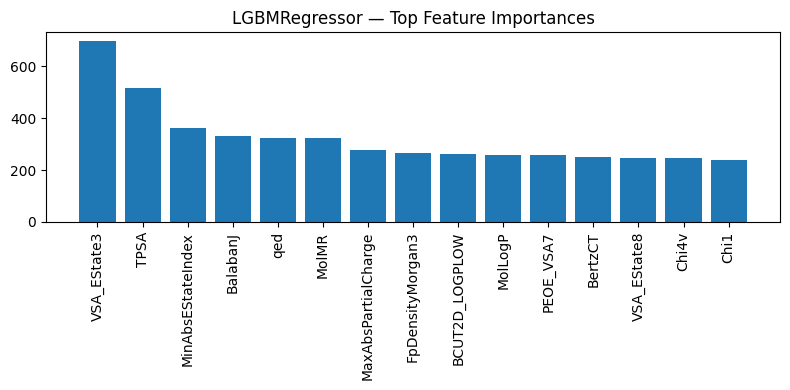

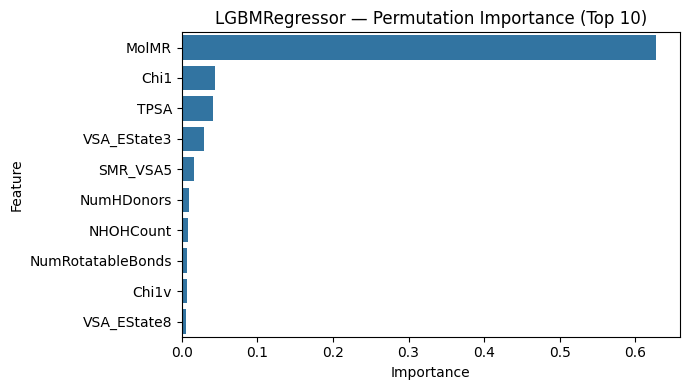


🔹 Training CatBoostRegressor...


Fitting CatBoostRegressor: 100%|██████████████████████████████████████| 1/1 [00:09<00:00,  9.23s/it]


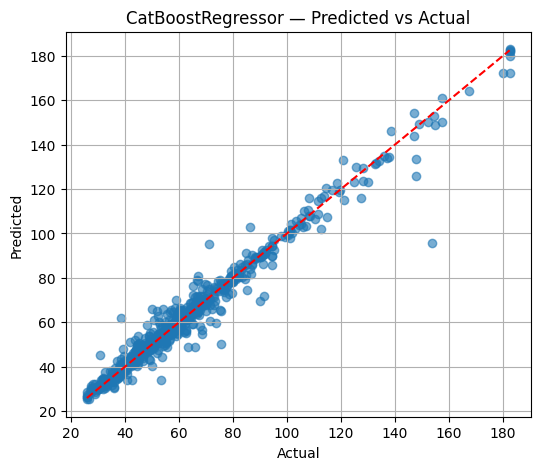

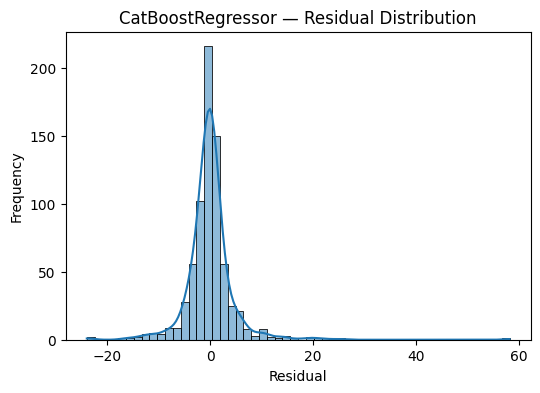

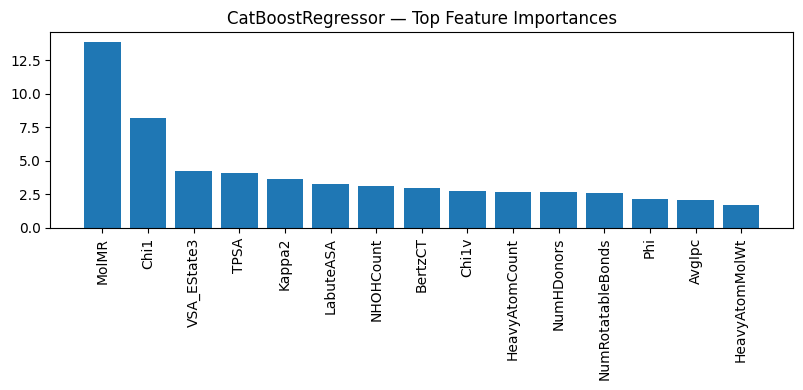

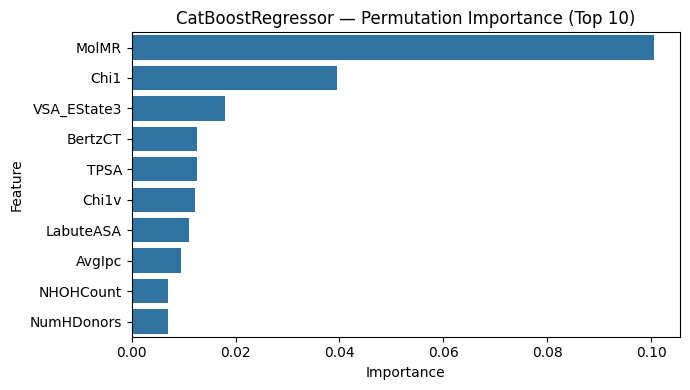

Model  Train_R2  Train_RMSE  Train_MAE   Test_R2  \
0            LinearRegression  0.951754    5.845383   3.845320  0.940837   
1       RandomForestRegressor  0.994210    2.024977   1.231177  0.958632   
2   GradientBoostingRegressor  0.983704    3.397229   2.514686  0.960853   
3                         SVR  0.622542   16.349981   9.394749  0.672518   
4                MLPRegressor  0.943177    6.343744   3.616367  0.932606   
5                       Ridge  0.949347    5.989402   3.860493  0.943031   
6                       Lasso  0.948377    6.046480   3.992831  0.941771   
7                  ElasticNet  0.947270    6.110988   3.969290  0.942828   
8                XGBRegressor  0.999446    0.626542   0.394938  0.962916   
9               LGBMRegressor  0.999324    0.692130   0.378858  0.969291   
10          CatBoostRegressor  0.997582    1.308529   0.973682  0.970724   

    Test_RMSE  Test_MAE  
0    6.785851  4.637217  
1    5.674266  3.410320  
2    5.519837  3.650189  
3   15.965125  9.388863  
4    7.242493  4.170954  
5    6.658808  4.524046  
6    6.732068  4.620270  
7    6.670702  4.556652  
8    5.372435  3.074765  
9    4.888918  2.870327  
10   4.773496  2.657183

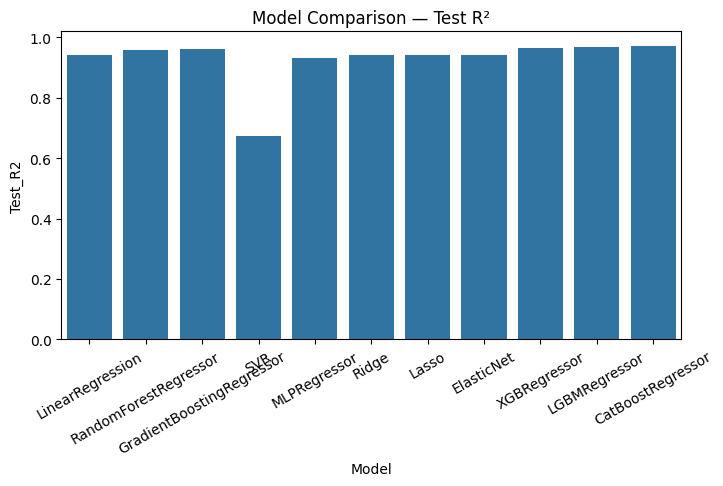

In [240]:

# -------------------------------------------
# Data split
# -------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# -------------------------------------------
# Helper function for metrics
# -------------------------------------------
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae}

# -------------------------------------------
# Training loop
# -------------------------------------------
results = []

for model in models:
    model_name = model.__class__.__name__
    print(f"\n🔹 Training {model_name}...")

    # tqdm progress for fit (especially for iterative models)
    pbar = tqdm(total=1, desc=f"Fitting {model_name}", ncols=100, colour="cyan")
    model.fit(X_train, y_train)
    pbar.update(1)
    pbar.close()

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    train_metrics = get_metrics(y_train, y_pred_train)
    test_metrics = get_metrics(y_test, y_pred_test)
    results.append({
        "Model": model_name,
        **{f"Train_{k}": v for k, v in train_metrics.items()},
        **{f"Test_{k}": v for k, v in test_metrics.items()}
    })

    # -------------------------------------------
    # 📈 Plot 1: Predicted vs Actual
    # -------------------------------------------
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.grid(True)
    plt.show()

    # -------------------------------------------
    # 📉 Plot 2: Residual Plot
    # -------------------------------------------
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{model_name} — Residual Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()

    # -------------------------------------------
    # 📊 Plot 3: Feature Importance (for tree models)
    # -------------------------------------------
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # top 15
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), np.array(X_train.columns)[indices], rotation=90)
        plt.title(f"{model_name} — Top Feature Importances")
        plt.tight_layout()
        plt.show()

    # -------------------------------------------
    # 📉 Plot 4: Loss Curve (if available)
    # -------------------------------------------
    if hasattr(model, "loss_curve_"):
        plt.figure(figsize=(6, 4))
        plt.plot(model.loss_curve_)
        plt.title(f"{model_name} — Training Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # -------------------------------------------
    # 📈 Plot 5: Permutation Importance (for all models)
    # -------------------------------------------
    try:
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=0)
        perm_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': perm_importance['importances_mean']
        }).sort_values(by='Importance', ascending=False).head(10)

        plt.figure(figsize=(7, 4))
        sns.barplot(x='Importance', y='Feature', data=perm_df)
        plt.title(f"{model_name} — Permutation Importance (Top 10)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Skipping permutation importance for {model_name}: {e}")

# -------------------------------------------
# 📊 Summary of All Models
# -------------------------------------------
results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="Test_R2", data=results_df)
plt.title("Model Comparison — Test R²")
plt.xticks(rotation=30)
plt.show()


In [241]:
results_df.to_csv('model_results_without_scaled.csv', index=False)

### Traing using Scaled values

In [242]:
final_data_scaled

CAS  VOC      dvap       num External           SMILES  \
0       872-05-9  YES -0.388855  0.319474      YES      CCCCCCCCC=C   
1     16747-26-5  YES -0.751714 -0.480040      YES  CCC(C)CC(C)(C)C   
2       111-84-2  YES -0.536961  3.517532      YES        CCCCCCCCC   
3       124-18-5  YES -0.348126  7.515105      YES       CCCCCCCCCC   
4      3522-94-9  YES -0.770227  0.319474      YES  CC(C)CCC(C)(C)C   
...          ...  ...       ...       ...      ...              ...   
2405  76474-09-4   NO -0.873901 -0.480040       NO     CC(C)(C#N)OC   
2406  25899-50-7   NO -0.659148 -0.480040       NO         CCC=CC#N   
2407  26294-98-4   NO -0.596203 -0.480040       NO         CCC=CC#N   
2408   1190-76-7   NO -0.818361 -0.480040       NO          CC=CC#N   
2409    627-26-9   NO -0.777632 -0.480040       NO          CC=CC#N   

                              Key        Family  MaxAbsEStateIndex  \
0     AFFLGGQVNFXPEV-UHFFFAOYSA-N  Hydrocarbons          -0.809588   
1     AFTPEBDOGXRMNQ-UHFFFAOYSA-N  Hydrocarbons          -1.187900   
2     BKIMMITUMNQMOS-UHFFFAOYSA-N  Hydrocarbons          -1.204729   
3     DIOQZVSQGTUSAI-UHFFFAOYSA-N  Hydrocarbons          -1.203024   
4     HHOSMYBYIHNXNO-UHFFFAOYSA-N  Hydrocarbons          -1.194439   
...                           ...           ...                ...   
2405  GREBWGAVFUQVPM-UHFFFAOYSA-N         Other           0.439775   
2406  ISBHMJZRKAFTGE-UHFFFAOYSA-N         Other           0.340786   
2407  ISBHMJZRKAFTGE-UHFFFAOYSA-N         Other           0.340786   
2408  NKKMVIVFRUYPLQ-UHFFFAOYSA-N         Other           0.304581   
2409  NKKMVIVFRUYPLQ-UHFFFAOYSA-N         Other           0.304581   

      MaxEStateIndex  ...  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0          -0.809588  ...    -0.02882          -0.053972           0.0   
1          -1.187900  ...    -0.02882          -0.053972           0.0   
2          -1.204729  ...    -0.02882          -0.053972           0.0   
3          -1.203024  ...    -0.02882          -0.053972           0.0   
4          -1.194439  ...    -0.02882          -0.053972           0.0   
...              ...  ...         ...                ...           ...   
2405        0.439775  ...    -0.02882          -0.053972           0.0   
2406        0.340786  ...    -0.02882          -0.053972           0.0   
2407        0.340786  ...    -0.02882          -0.053972           0.0   
2408        0.304581  ...    -0.02882          -0.053972           0.0   
2409        0.304581  ...    -0.02882          -0.053972           0.0   

      fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  \
0       -0.020374          0.0     -0.117826          0.580434      0.0   
1       -0.020374          0.0     -0.117826         -0.350475      0.0   
2       -0.020374          0.0     -0.117826          0.580434      0.0   
3       -0.020374          0.0     -0.117826          0.735585      0.0   
4       -0.020374          0.0     -0.117826         -0.350475      0.0   
...           ...          ...           ...               ...      ...   
2405    -0.020374          0.0     -0.117826         -0.350475      0.0   
2406    -0.020374          0.0     -0.117826         -0.350475      0.0   
2407    -0.020374          0.0     -0.117826         -0.350475      0.0   
2408    -0.020374          0.0     -0.117826         -0.350475      0.0   
2409    -0.020374          0.0     -0.117826         -0.350475      0.0   

      dvap_log  dvap_scaled  
0    -0.280987    -0.280987  
1    -0.832119    -0.832119  
2    -0.492092    -0.492092  
3    -0.225805    -0.225805  
4    -0.863616    -0.863616  
...        ...          ...  
2405 -1.047380    -1.047380  
2406 -0.680097    -0.680097  
2407 -0.581557    -0.581557  
2408 -0.947329    -0.947329  
2409 -0.876321    -0.876321  

[2410 rows x 226 columns]

In [243]:
exclude_cols = ['CAS', 'VOC', 'dvap', 'num', 'External', 'SMILES', 'Key', 'Family','dvap_log','dvap_scaled']
X_names = [col for col in final_data_scaled.columns if col not in exclude_cols]
X = final_data_scaled.drop(columns=exclude_cols)
y = final_data_scaled['dvap_scaled'].to_numpy()


🔹 Training LinearRegression...


Fitting LinearRegression: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 20.34it/s]


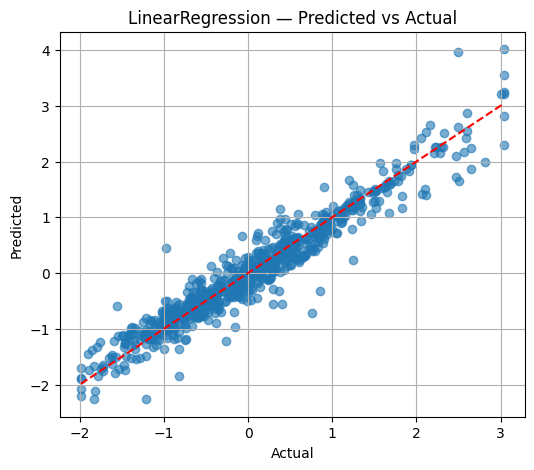

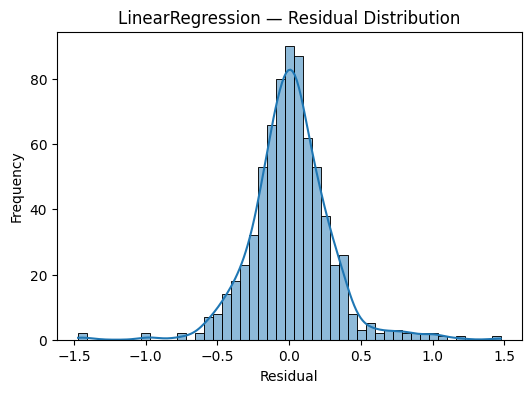

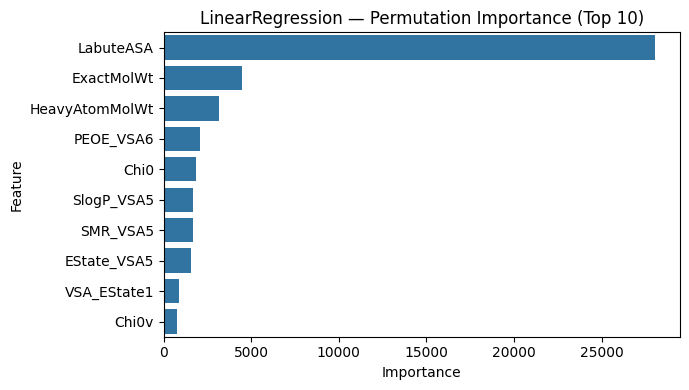


🔹 Training RandomForestRegressor...


Fitting RandomForestRegressor: 100%|██████████████████████████████████| 1/1 [00:15<00:00, 15.89s/it]


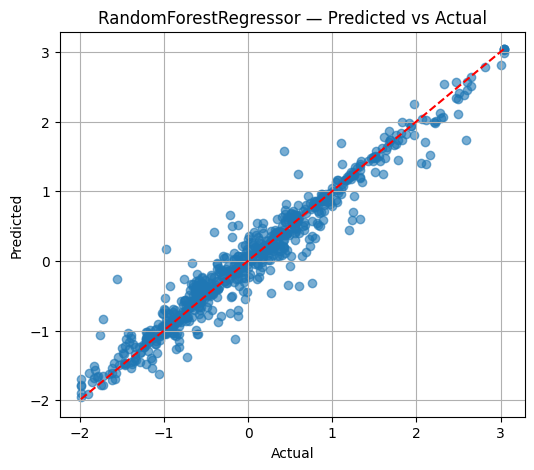

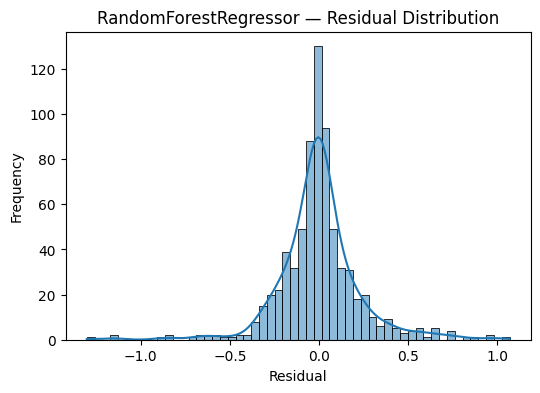

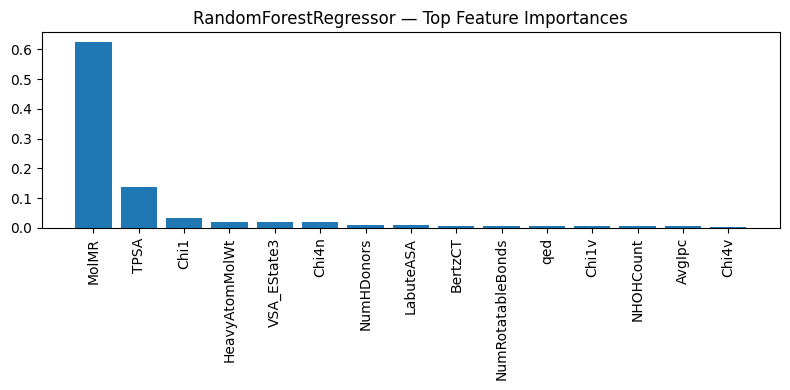

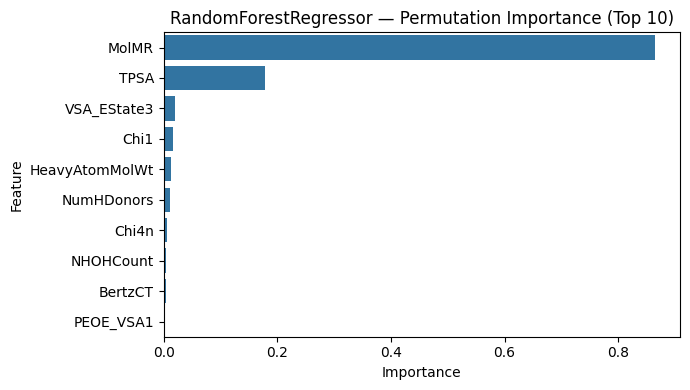


🔹 Training GradientBoostingRegressor...


Fitting GradientBoostingRegressor: 100%|██████████████████████████████| 1/1 [00:06<00:00,  6.53s/it]


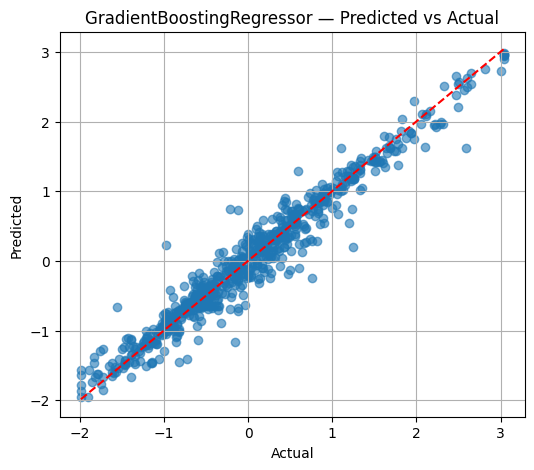

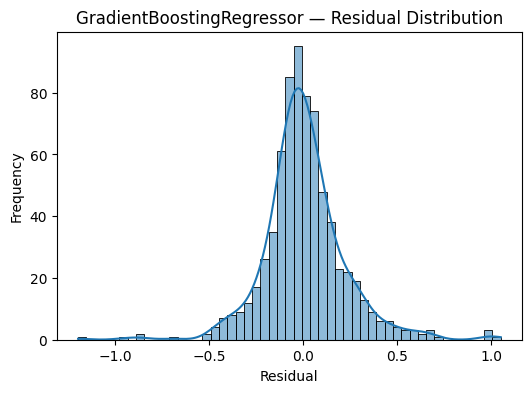

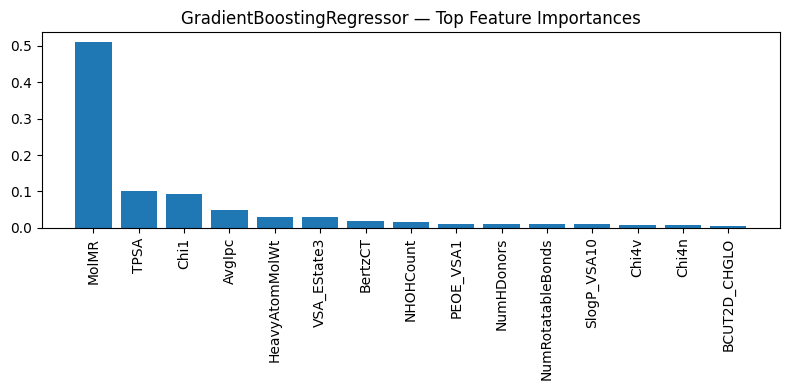

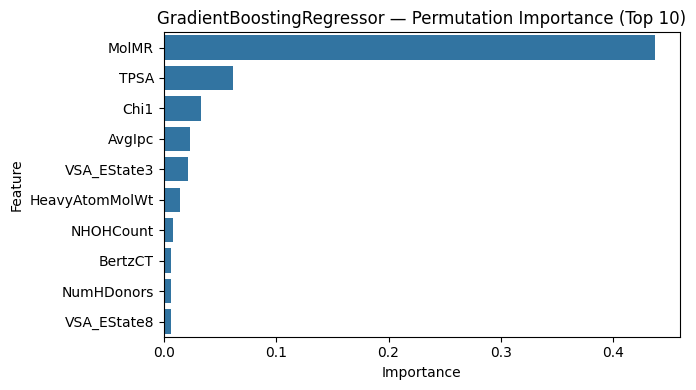


🔹 Training SVR...


Fitting SVR: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


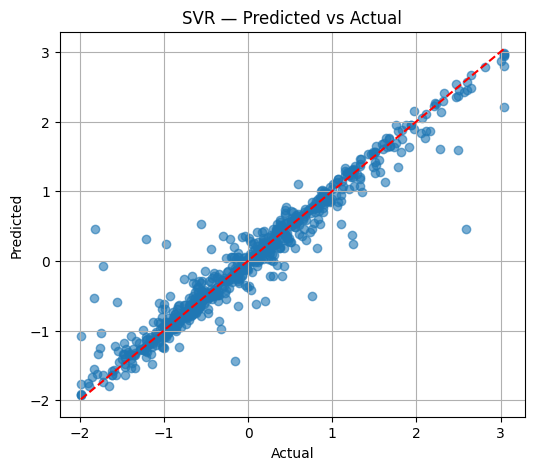

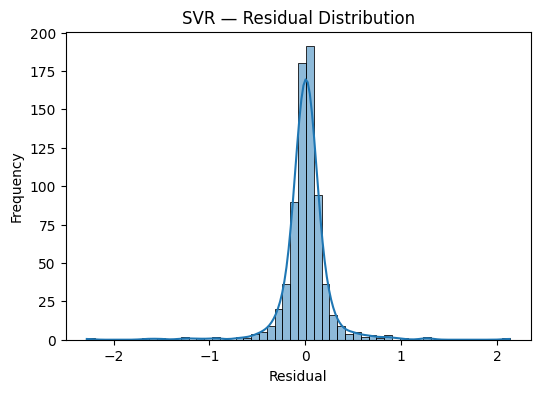

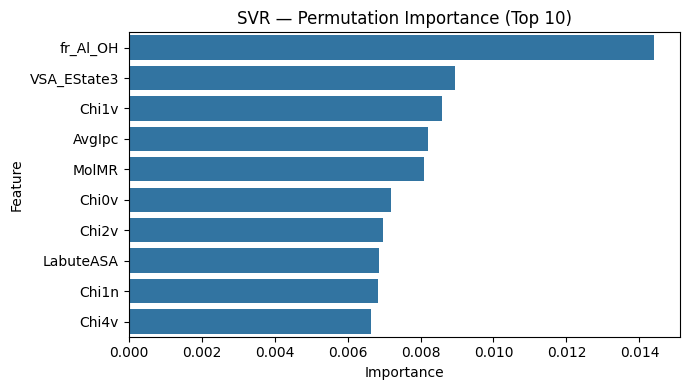


🔹 Training MLPRegressor...


Fitting MLPRegressor: 100%|███████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


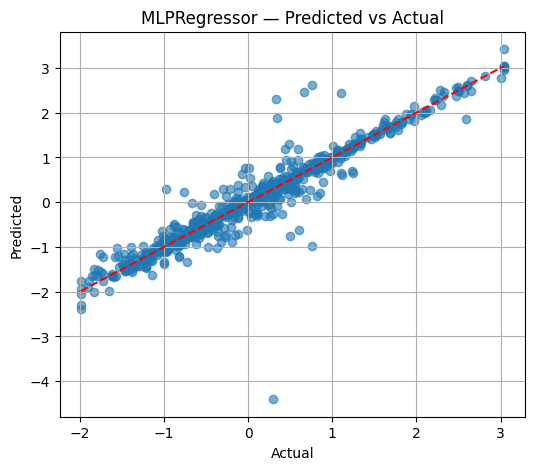

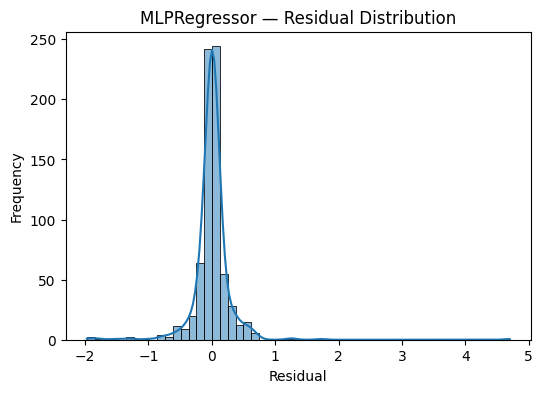

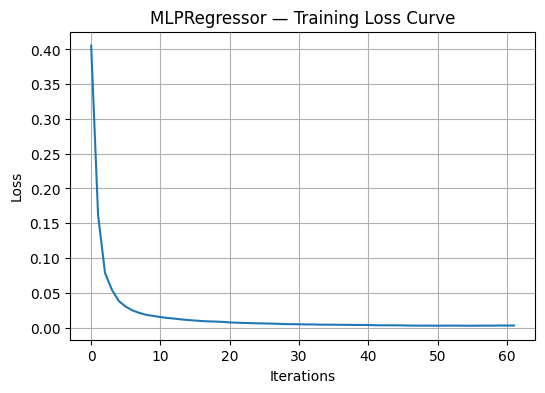

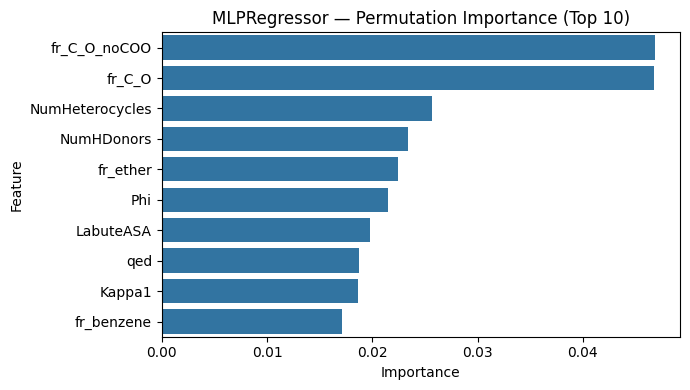


🔹 Training Ridge...


Fitting Ridge: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 130.04it/s]


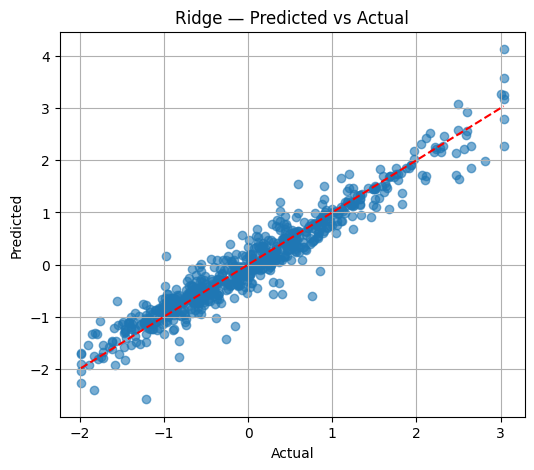

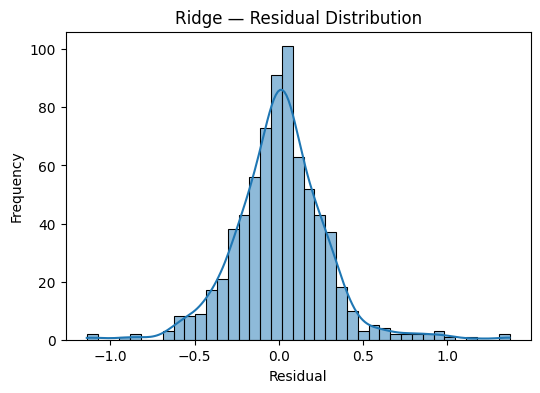

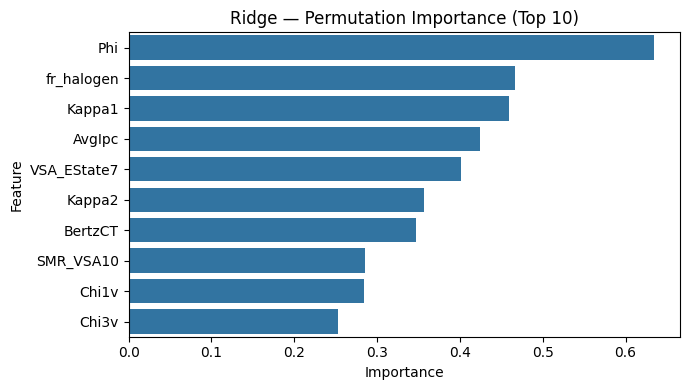


🔹 Training Lasso...


Fitting Lasso:   0%|                                                          | 0/1 [00:00<?, ?it/s]c:\AYUSH\Ayush\IIT KANPUR\SEMESTER 5\CHE657\PROJECT\che\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e+00, tolerance: 1.670e-01
  model = cd_fast.enet_coordinate_descent(
Fitting Lasso: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


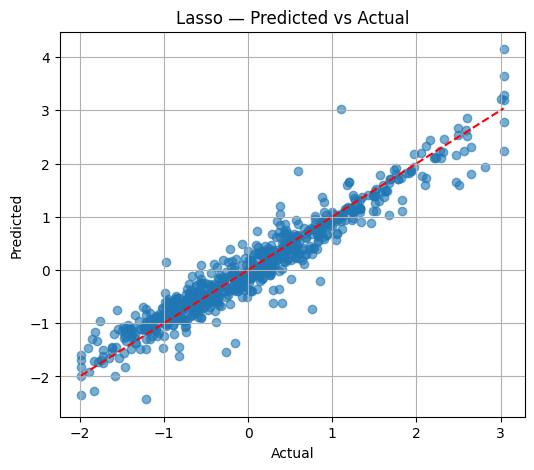

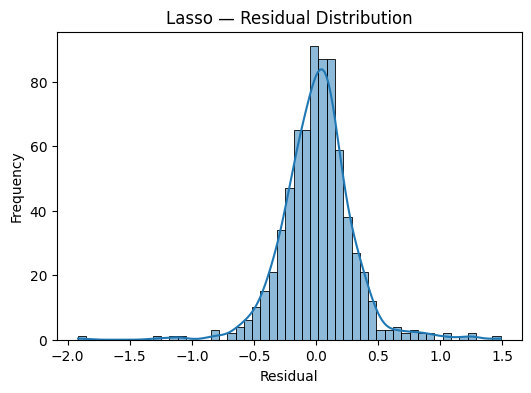

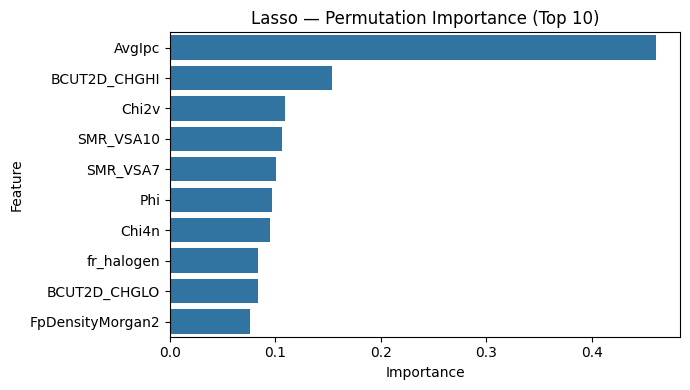


🔹 Training ElasticNet...


Fitting ElasticNet:   0%|                                                     | 0/1 [00:00<?, ?it/s]c:\AYUSH\Ayush\IIT KANPUR\SEMESTER 5\CHE657\PROJECT\che\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e+01, tolerance: 1.670e-01
  model = cd_fast.enet_coordinate_descent(
Fitting ElasticNet: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


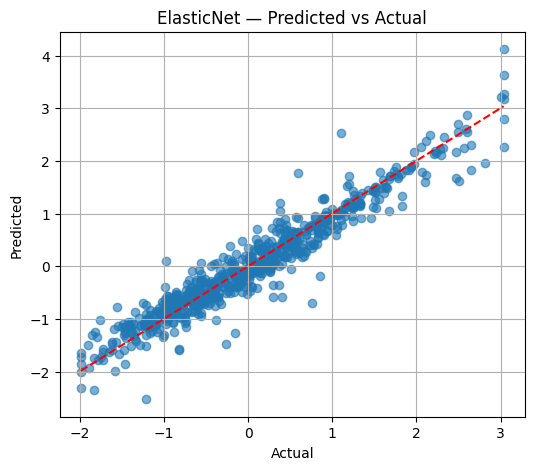

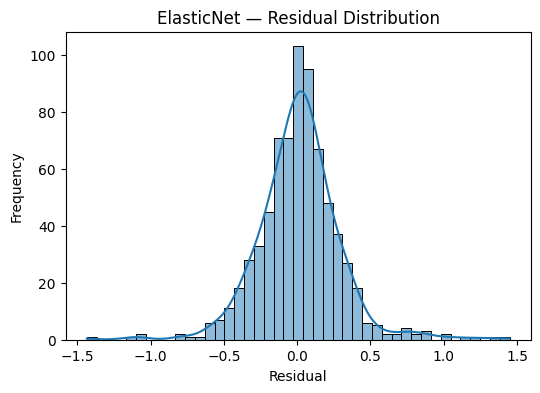

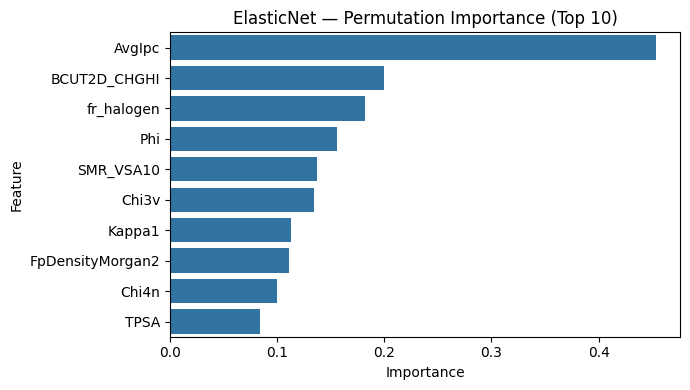


🔹 Training XGBRegressor...


Fitting XGBRegressor: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


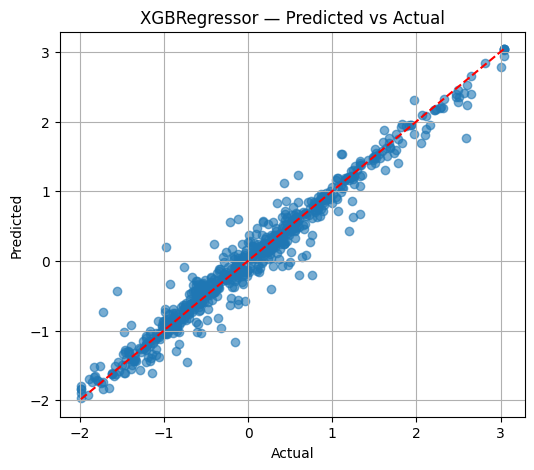

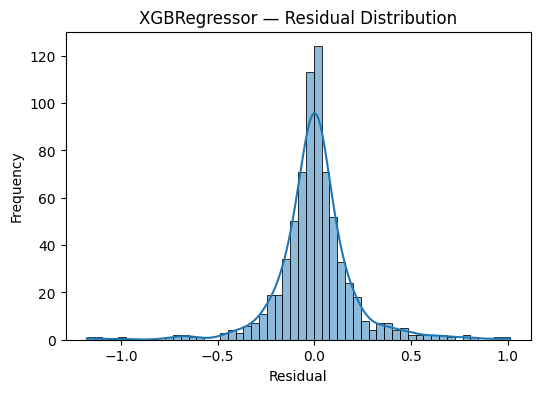

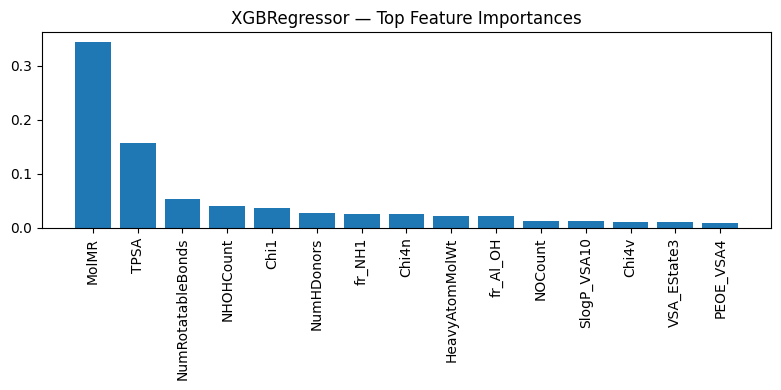

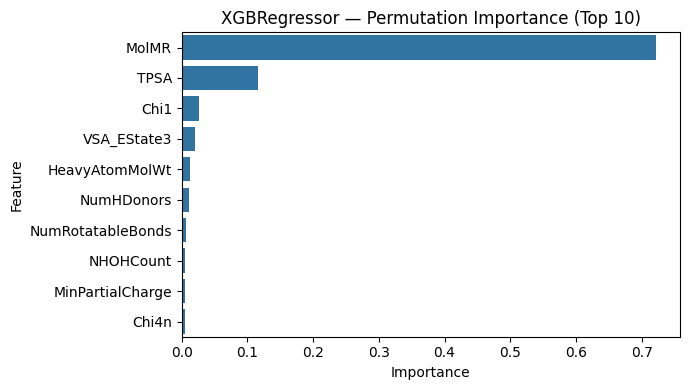


🔹 Training LGBMRegressor...


Fitting LGBMRegressor:   0%|                                                  | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16843
[LightGBM] [Info] Number of data points in the train set: 1687, number of used features: 163
[LightGBM] [Info] Start training from score -0.008457


Fitting LGBMRegressor: 100%|██████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


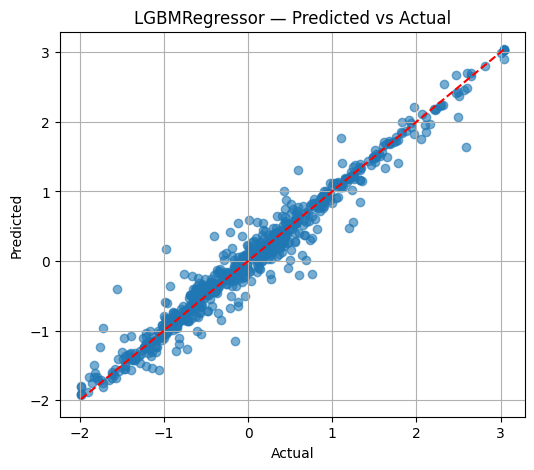

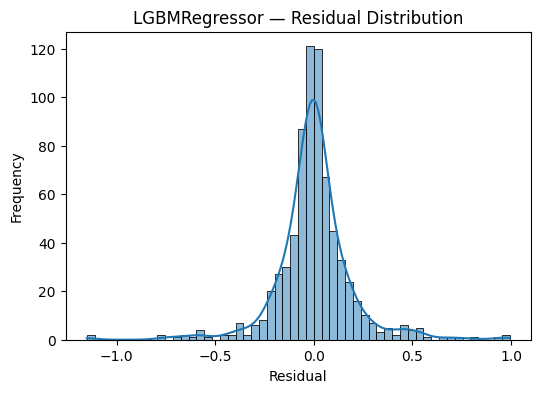

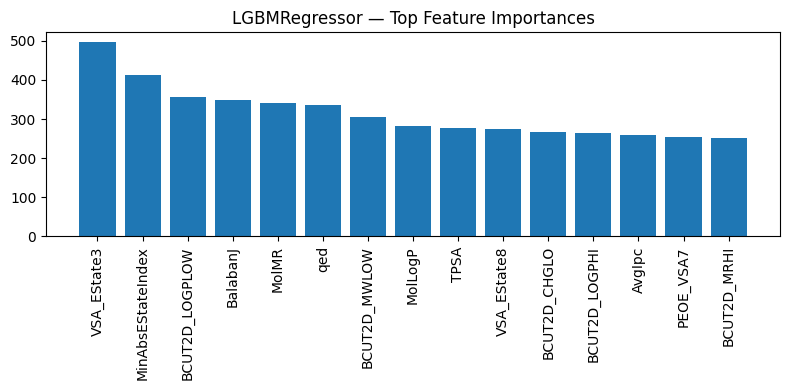

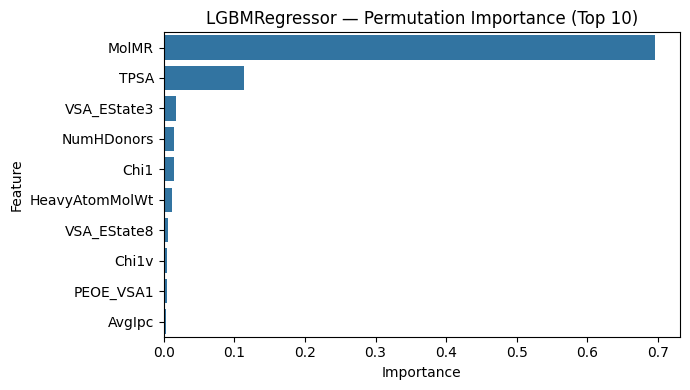


🔹 Training CatBoostRegressor...


Fitting CatBoostRegressor: 100%|██████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


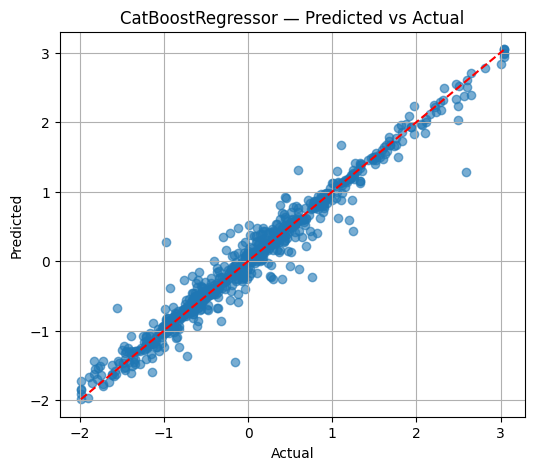

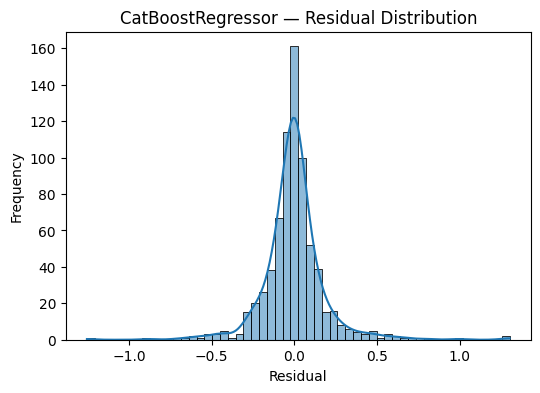

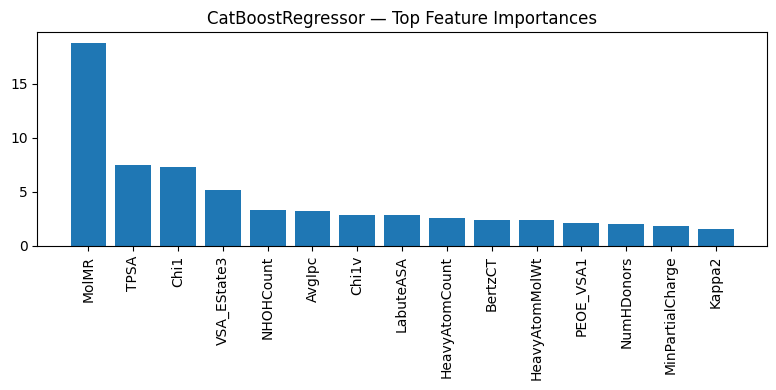

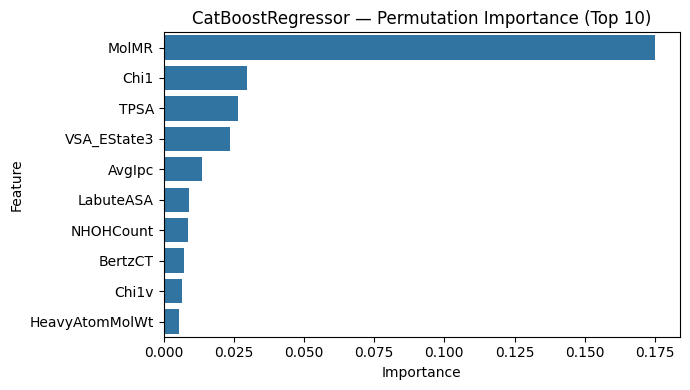

Model  Train_R2  Train_RMSE  Train_MAE   Test_R2  \
0            LinearRegression  0.950370    0.221649   0.160711  0.924784   
1       RandomForestRegressor  0.993472    0.080386   0.052686  0.947971   
2   GradientBoostingRegressor  0.979651    0.141925   0.106867  0.953780   
3                         SVR  0.985316    0.120563   0.085536  0.936519   
4                MLPRegressor  0.995538    0.066463   0.047213  0.901286   
5                       Ridge  0.945290    0.232716   0.169091  0.925796   
6                       Lasso  0.937517    0.248697   0.182229  0.917326   
7                  ElasticNet  0.940961    0.241747   0.176499  0.922298   
8                XGBRegressor  0.999391    0.024554   0.015140  0.960275   
9               LGBMRegressor  0.999335    0.025659   0.014890  0.962366   
10          CatBoostRegressor  0.996752    0.056706   0.042585  0.964681   

    Test_RMSE  Test_MAE  
0    0.277399  0.195880  
1    0.230713  0.147416  
2    0.217452  0.149475  
3    0.254841  0.138746  
4    0.317789  0.151863  
5    0.275526  0.196642  
6    0.290825  0.203955  
7    0.281945  0.199421  
8    0.201595  0.125780  
9    0.196218  0.121068  
10   0.190086  0.115394

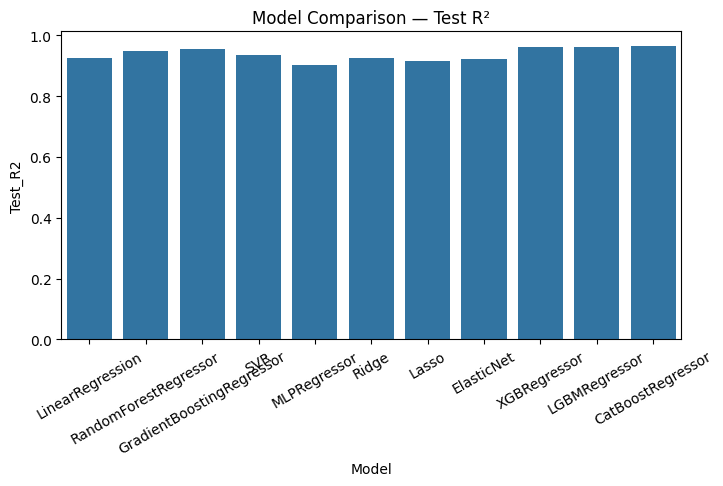

In [244]:



# -------------------------------------------
# Data split
# -------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# -------------------------------------------
# Helper function for metrics
# -------------------------------------------
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae}

# -------------------------------------------
# Training loop
# -------------------------------------------
results = []

for model in models:
    model_name = model.__class__.__name__
    print(f"\n🔹 Training {model_name}...")

    # tqdm progress for fit (especially for iterative models)
    pbar = tqdm(total=1, desc=f"Fitting {model_name}", ncols=100, colour="cyan")
    model.fit(X_train, y_train)
    pbar.update(1)
    pbar.close()

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    train_metrics = get_metrics(y_train, y_pred_train)
    test_metrics = get_metrics(y_test, y_pred_test)
    results.append({
        "Model": model_name,
        **{f"Train_{k}": v for k, v in train_metrics.items()},
        **{f"Test_{k}": v for k, v in test_metrics.items()}
    })

    # -------------------------------------------
    # 📈 Plot 1: Predicted vs Actual
    # -------------------------------------------
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.grid(True)
    plt.show()

    # -------------------------------------------
    # 📉 Plot 2: Residual Plot
    # -------------------------------------------
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{model_name} — Residual Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()

    # -------------------------------------------
    # 📊 Plot 3: Feature Importance (for tree models)
    # -------------------------------------------
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:15]  # top 15
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), np.array(X_train.columns)[indices], rotation=90)
        plt.title(f"{model_name} — Top Feature Importances")
        plt.tight_layout()
        plt.show()

    # -------------------------------------------
    # 📉 Plot 4: Loss Curve (if available)
    # -------------------------------------------
    if hasattr(model, "loss_curve_"):
        plt.figure(figsize=(6, 4))
        plt.plot(model.loss_curve_)
        plt.title(f"{model_name} — Training Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # -------------------------------------------
    # 📈 Plot 5: Permutation Importance (for all models)
    # -------------------------------------------
    try:
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=0)
        perm_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': perm_importance['importances_mean']
        }).sort_values(by='Importance', ascending=False).head(10)

        plt.figure(figsize=(7, 4))
        sns.barplot(x='Importance', y='Feature', data=perm_df)
        plt.title(f"{model_name} — Permutation Importance (Top 10)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Skipping permutation importance for {model_name}: {e}")

# -------------------------------------------
# 📊 Summary of All Models
# -------------------------------------------
results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="Test_R2", data=results_df)
plt.title("Model Comparison — Test R²")
plt.xticks(rotation=30)
plt.show()


In [245]:
results_df.to_csv('scaled_model_results.csv', index=False)


### Comparison of scalling and not scalling model 

In [9]:
scaled_result=pd.read_csv('scaled_model_results.csv')
not_scaled_result=pd.read_csv('model_results_without_scaled.csv')


In [10]:
scaled_result

Model  Train_R2  Train_RMSE  Train_MAE   Test_R2  \
0            LinearRegression  0.950370    0.221649   0.160711  0.924784   
1       RandomForestRegressor  0.993472    0.080386   0.052686  0.947971   
2   GradientBoostingRegressor  0.979651    0.141925   0.106867  0.953780   
3                         SVR  0.985316    0.120563   0.085536  0.936519   
4                MLPRegressor  0.995538    0.066463   0.047213  0.901286   
5                       Ridge  0.945290    0.232716   0.169091  0.925796   
6                       Lasso  0.937517    0.248697   0.182229  0.917326   
7                  ElasticNet  0.940961    0.241747   0.176499  0.922298   
8                XGBRegressor  0.999391    0.024554   0.015140  0.960275   
9               LGBMRegressor  0.999335    0.025659   0.014890  0.962366   
10          CatBoostRegressor  0.996752    0.056706   0.042585  0.964681   

    Test_RMSE  Test_MAE  
0    0.277399  0.195880  
1    0.230713  0.147416  
2    0.217452  0.149475  
3    0.254841  0.138746  
4    0.317789  0.151863  
5    0.275526  0.196642  
6    0.290825  0.203955  
7    0.281945  0.199421  
8    0.201595  0.125780  
9    0.196218  0.121068  
10   0.190086  0.115394

In [11]:
not_scaled_result

Model  Train_R2  Train_RMSE  Train_MAE   Test_R2  \
0            LinearRegression  0.951754    5.845383   3.845320  0.940837   
1       RandomForestRegressor  0.994210    2.024977   1.231177  0.958632   
2   GradientBoostingRegressor  0.983704    3.397229   2.514686  0.960853   
3                         SVR  0.622542   16.349981   9.394749  0.672518   
4                MLPRegressor  0.943177    6.343744   3.616367  0.932606   
5                       Ridge  0.949347    5.989402   3.860493  0.943031   
6                       Lasso  0.948377    6.046480   3.992831  0.941771   
7                  ElasticNet  0.947270    6.110988   3.969290  0.942828   
8                XGBRegressor  0.999446    0.626542   0.394938  0.962916   
9               LGBMRegressor  0.999324    0.692130   0.378858  0.969291   
10          CatBoostRegressor  0.997582    1.308529   0.973682  0.970724   

    Test_RMSE  Test_MAE  
0    6.785851  4.637217  
1    5.674266  3.410320  
2    5.519837  3.650189  
3   15.965125  9.388863  
4    7.242493  4.170954  
5    6.658808  4.524046  
6    6.732068  4.620270  
7    6.670702  4.556652  
8    5.372435  3.074765  
9    4.888918  2.870327  
10   4.773496  2.657183

In [12]:
import pandas as pd

comparison = scaled_result.copy()
comparison = comparison.merge(not_scaled_result, on='Model', suffixes=('_Scaled', '_NotScaled'))
print(comparison)


                        Model  Train_R2_Scaled  Train_RMSE_Scaled  \
0            LinearRegression         0.950370           0.221649   
1       RandomForestRegressor         0.993472           0.080386   
2   GradientBoostingRegressor         0.979651           0.141925   
3                         SVR         0.985316           0.120563   
4                MLPRegressor         0.995538           0.066463   
5                       Ridge         0.945290           0.232716   
6                       Lasso         0.937517           0.248697   
7                  ElasticNet         0.940961           0.241747   
8                XGBRegressor         0.999391           0.024554   
9               LGBMRegressor         0.999335           0.025659   
10          CatBoostRegressor         0.996752           0.056706   

    Train_MAE_Scaled  Test_R2_Scaled  Test_RMSE_Scaled  Test_MAE_Scaled  \
0           0.160711        0.924784          0.277399         0.195880   
1           0.052686 

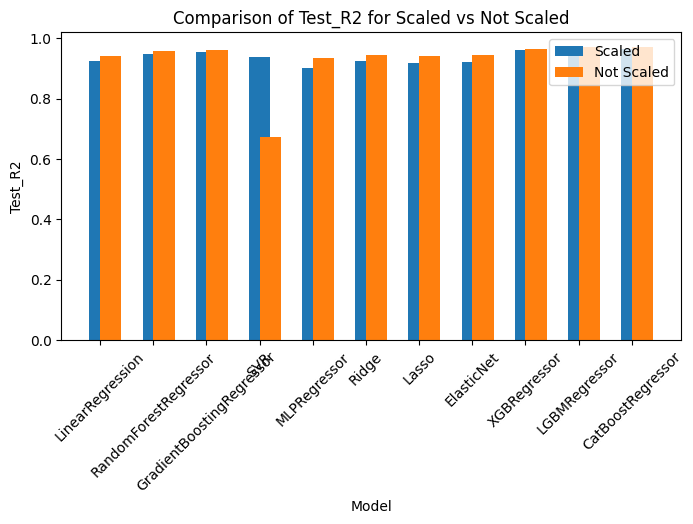

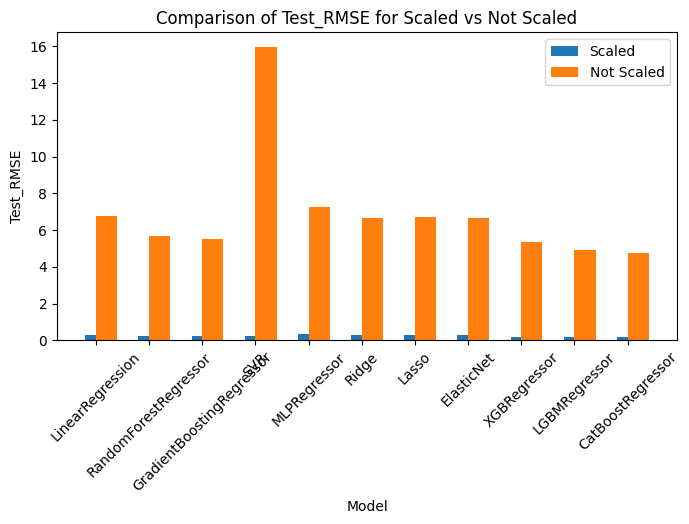

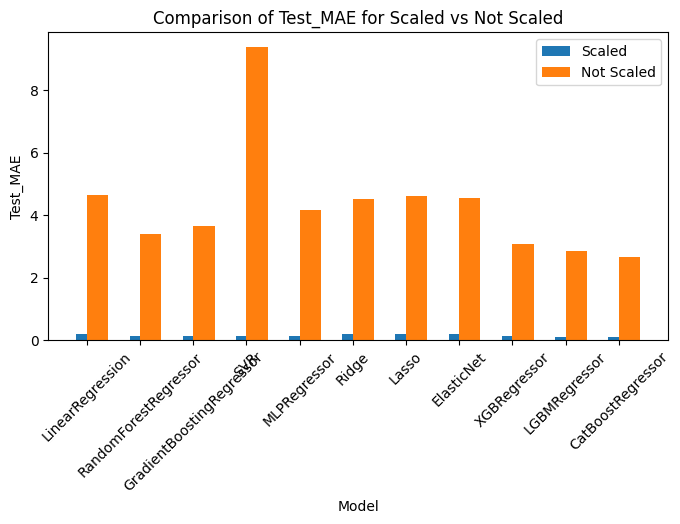

In [14]:
import matplotlib.pyplot as plt

metrics = ['Test_R2', 'Test_RMSE', 'Test_MAE']  # Change based on your columns

for metric in metrics:
    plt.figure(figsize=(8, 4))
    plt.bar(comparison['Model'], comparison[f'{metric}_Scaled'], width=0.4, label='Scaled', align='center')
    plt.bar(comparison['Model'], comparison[f'{metric}_NotScaled'], width=0.4, label='Not Scaled', align='edge')
    plt.title(f'Comparison of {metric} for Scaled vs Not Scaled')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
